In [2]:
from plot import get_cost_recovery, get_price_duration, get_load_duration

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pypsa
import pandas as pd
import numpy as np
plt.style.use(["bmh", "../../matplotlibrc"])

In [4]:
fn = "../..//data/time_series_60min_singleindex_filtered.csv"
history = pd.read_csv(fn, index_col=0)["DE_LU_price_day_ahead"].dropna().sort_values(ascending=False).reset_index(drop=True)
history.index = np.arange(0, 100, 100 / len(history.index))

In [13]:
files = {
    "inelastic": "../../results/35a-35a/network_solved_LT-country+DE-number_years+35-inelastic+true.nc",
    "VOLL 2000 €/MWh": "../../results/35a-35a/network_solved_LT-country+DE-number_years+35-voll+true.nc",
    "elasticity -5.3% @ 100 €/MWh": "../../results/35a-35a/network_solved_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000.nc",
    "50:50 VOLL & elasticity": "../../results/35a-35a/network_solved_LT-country+DE-number_years+35-elastic+true-voll+true-elastic_intercept+2000-voll_share+0.5.nc",
    "elasticity -100% @ 100 €/MWh": "../../results/35a-35a/network_solved_LT-country+DE-number_years+35-elastic+true-elastic_intercept+200.nc",
    "elasticity -0.5% @ 100 €/MWh": "../../results/35a-35a/network_solved_LT-country+DE-number_years+35-elastic+true-elastic_intercept+20000.nc",
}

In [14]:
ns = {k: pypsa.Network(v) for k, v in files.items()}

INFO:pypsa.io:Imported network network_solved_LT-country+DE-number_years+35-inelastic+true.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-number_years+35-voll+true.nc has buses, carriers, generators, links, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-number_years+35-elastic+true-voll+true-elastic_intercept+2000-voll_share+0.5.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-number_years+35-elastic+true-elastic_intercept+200.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_solved_LT-country+DE-number_years+35-elastic+true-elastic_intercept+20000.nc has buses, carriers, generators, links, loads, stores


In [15]:
lmp = pd.DataFrame({k: get_annual_mean_lmp(v) for k, v in ns.items()})


In [16]:

to_drop = ["elasticity -100% @ 100 €/MWh", "elasticity -0.5% @ 100 €/MWh"]
lmp.drop(to_drop, errors='ignore', axis=1, inplace=True)

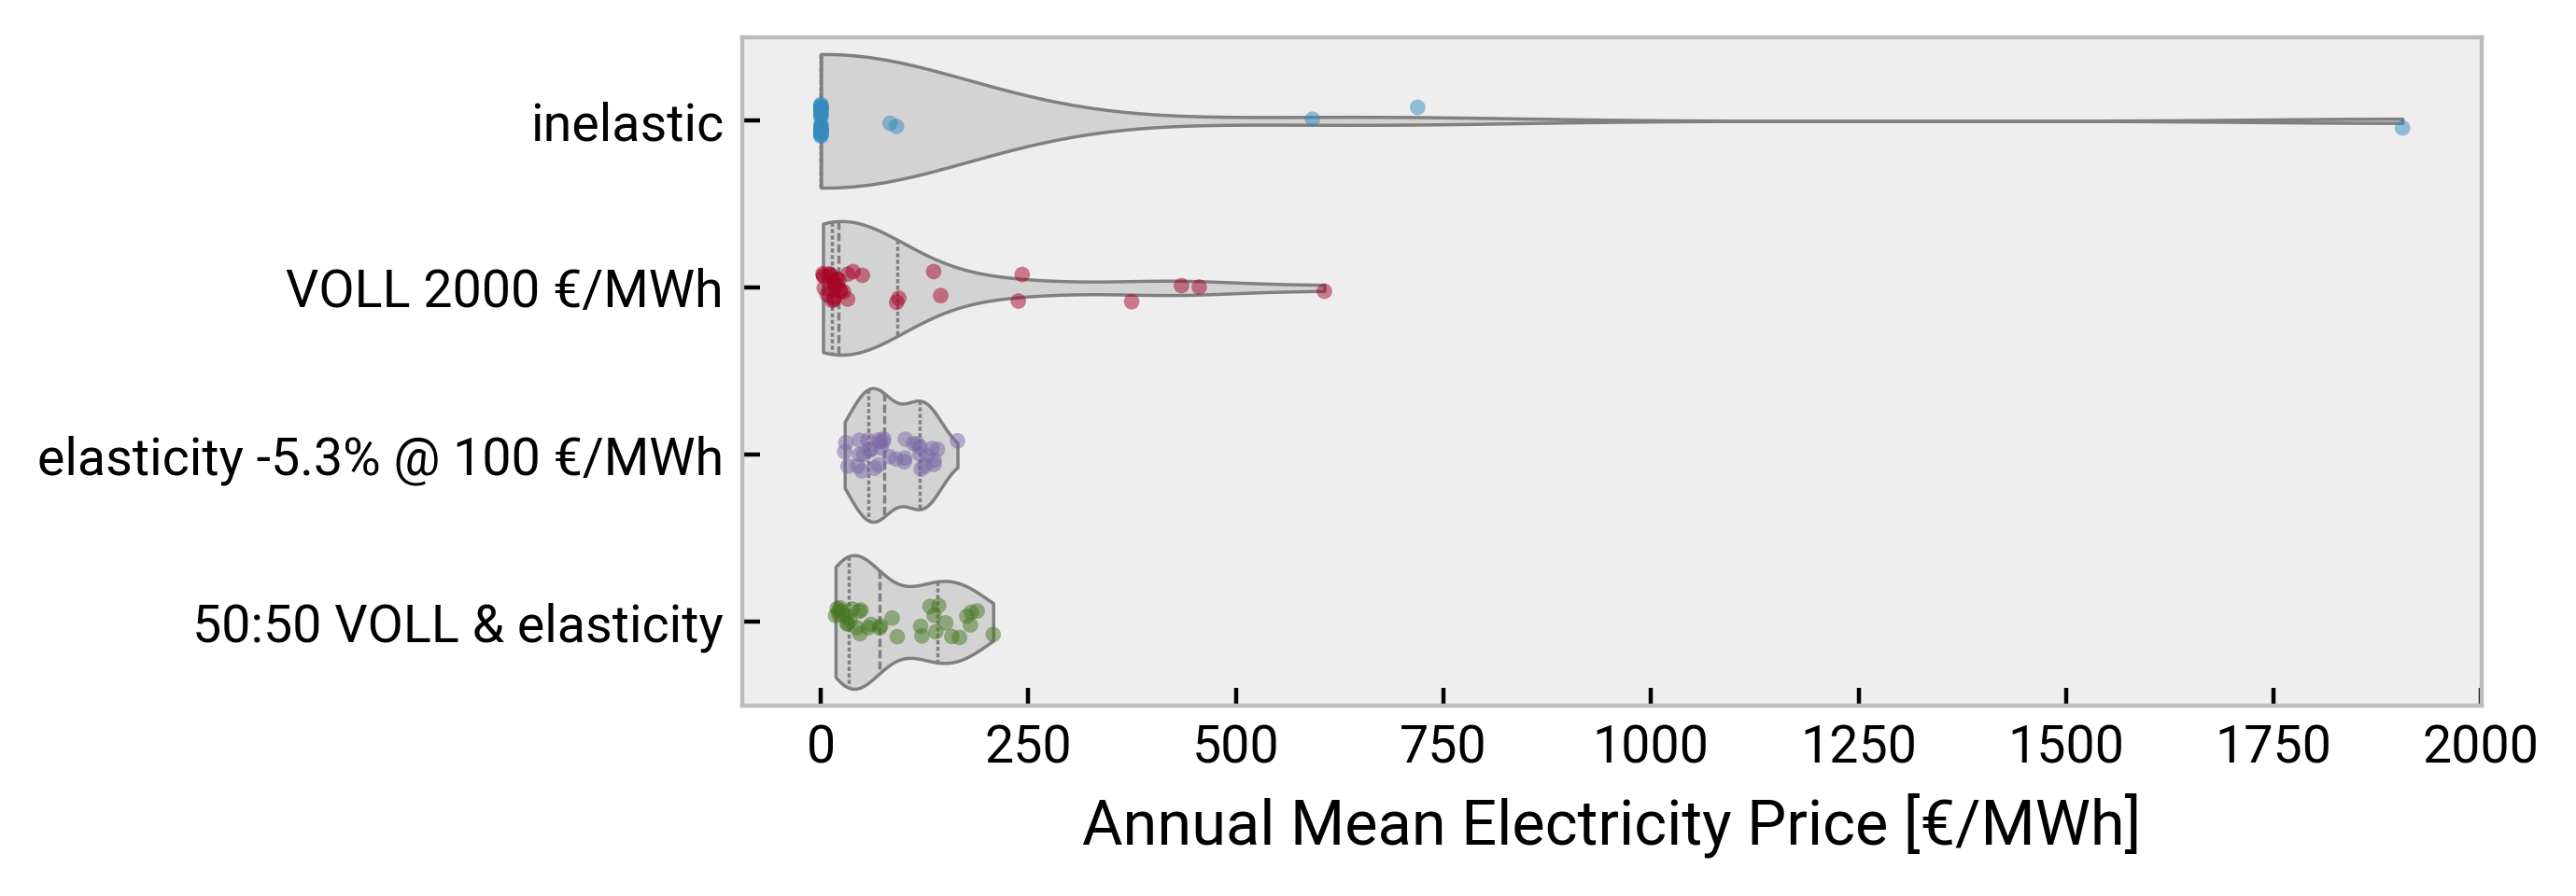

In [17]:
def get_annual_mean_lmp(n):
    lmp = n.buses_t.marginal_price["electricity"]
    return lmp.groupby(lmp.index.year).mean()



fig, ax = plt.subplots(figsize=(7, 2.5))
sns.stripplot(lmp, ax=ax, orient="h", alpha=0.5, size=3)
sns.violinplot(lmp, ax=ax, orient="h", facecolor='lightgrey', edgecolor='grey', inner='quart', cut=0)

plt.xlabel("Annual Mean Electricity Price [€/MWh]")

plt.savefig(f"../../slides/graphics/annual-prices.pdf", bbox_inches='tight')

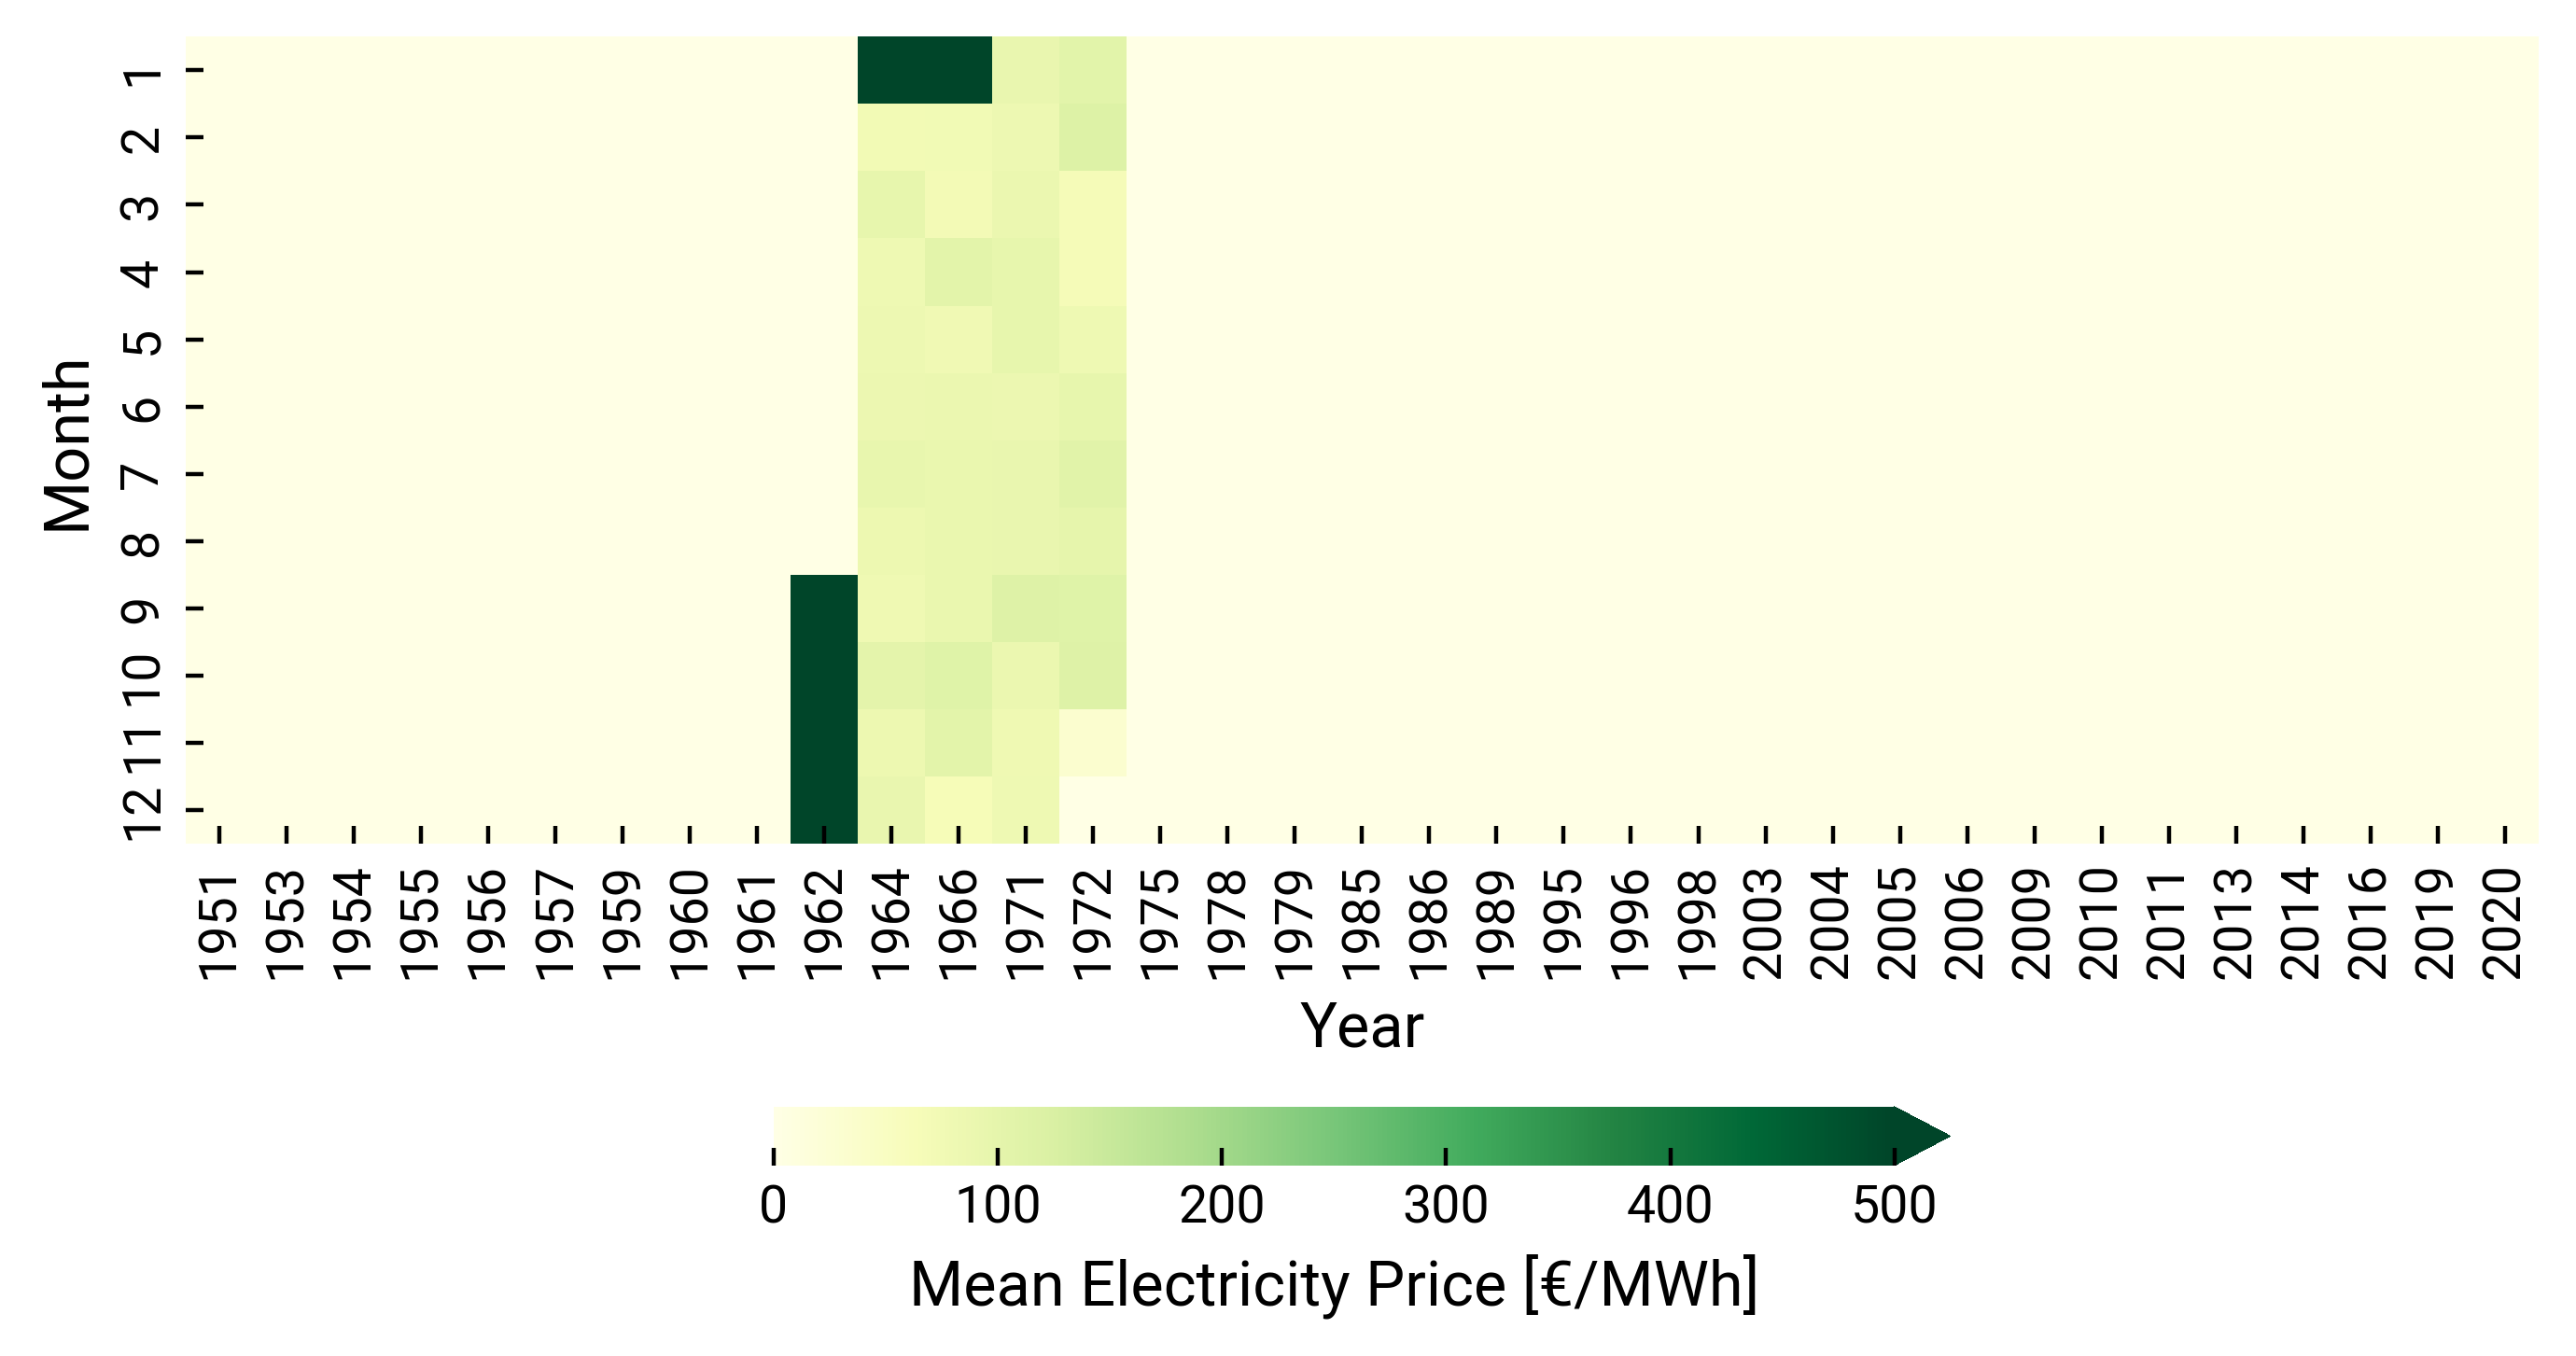

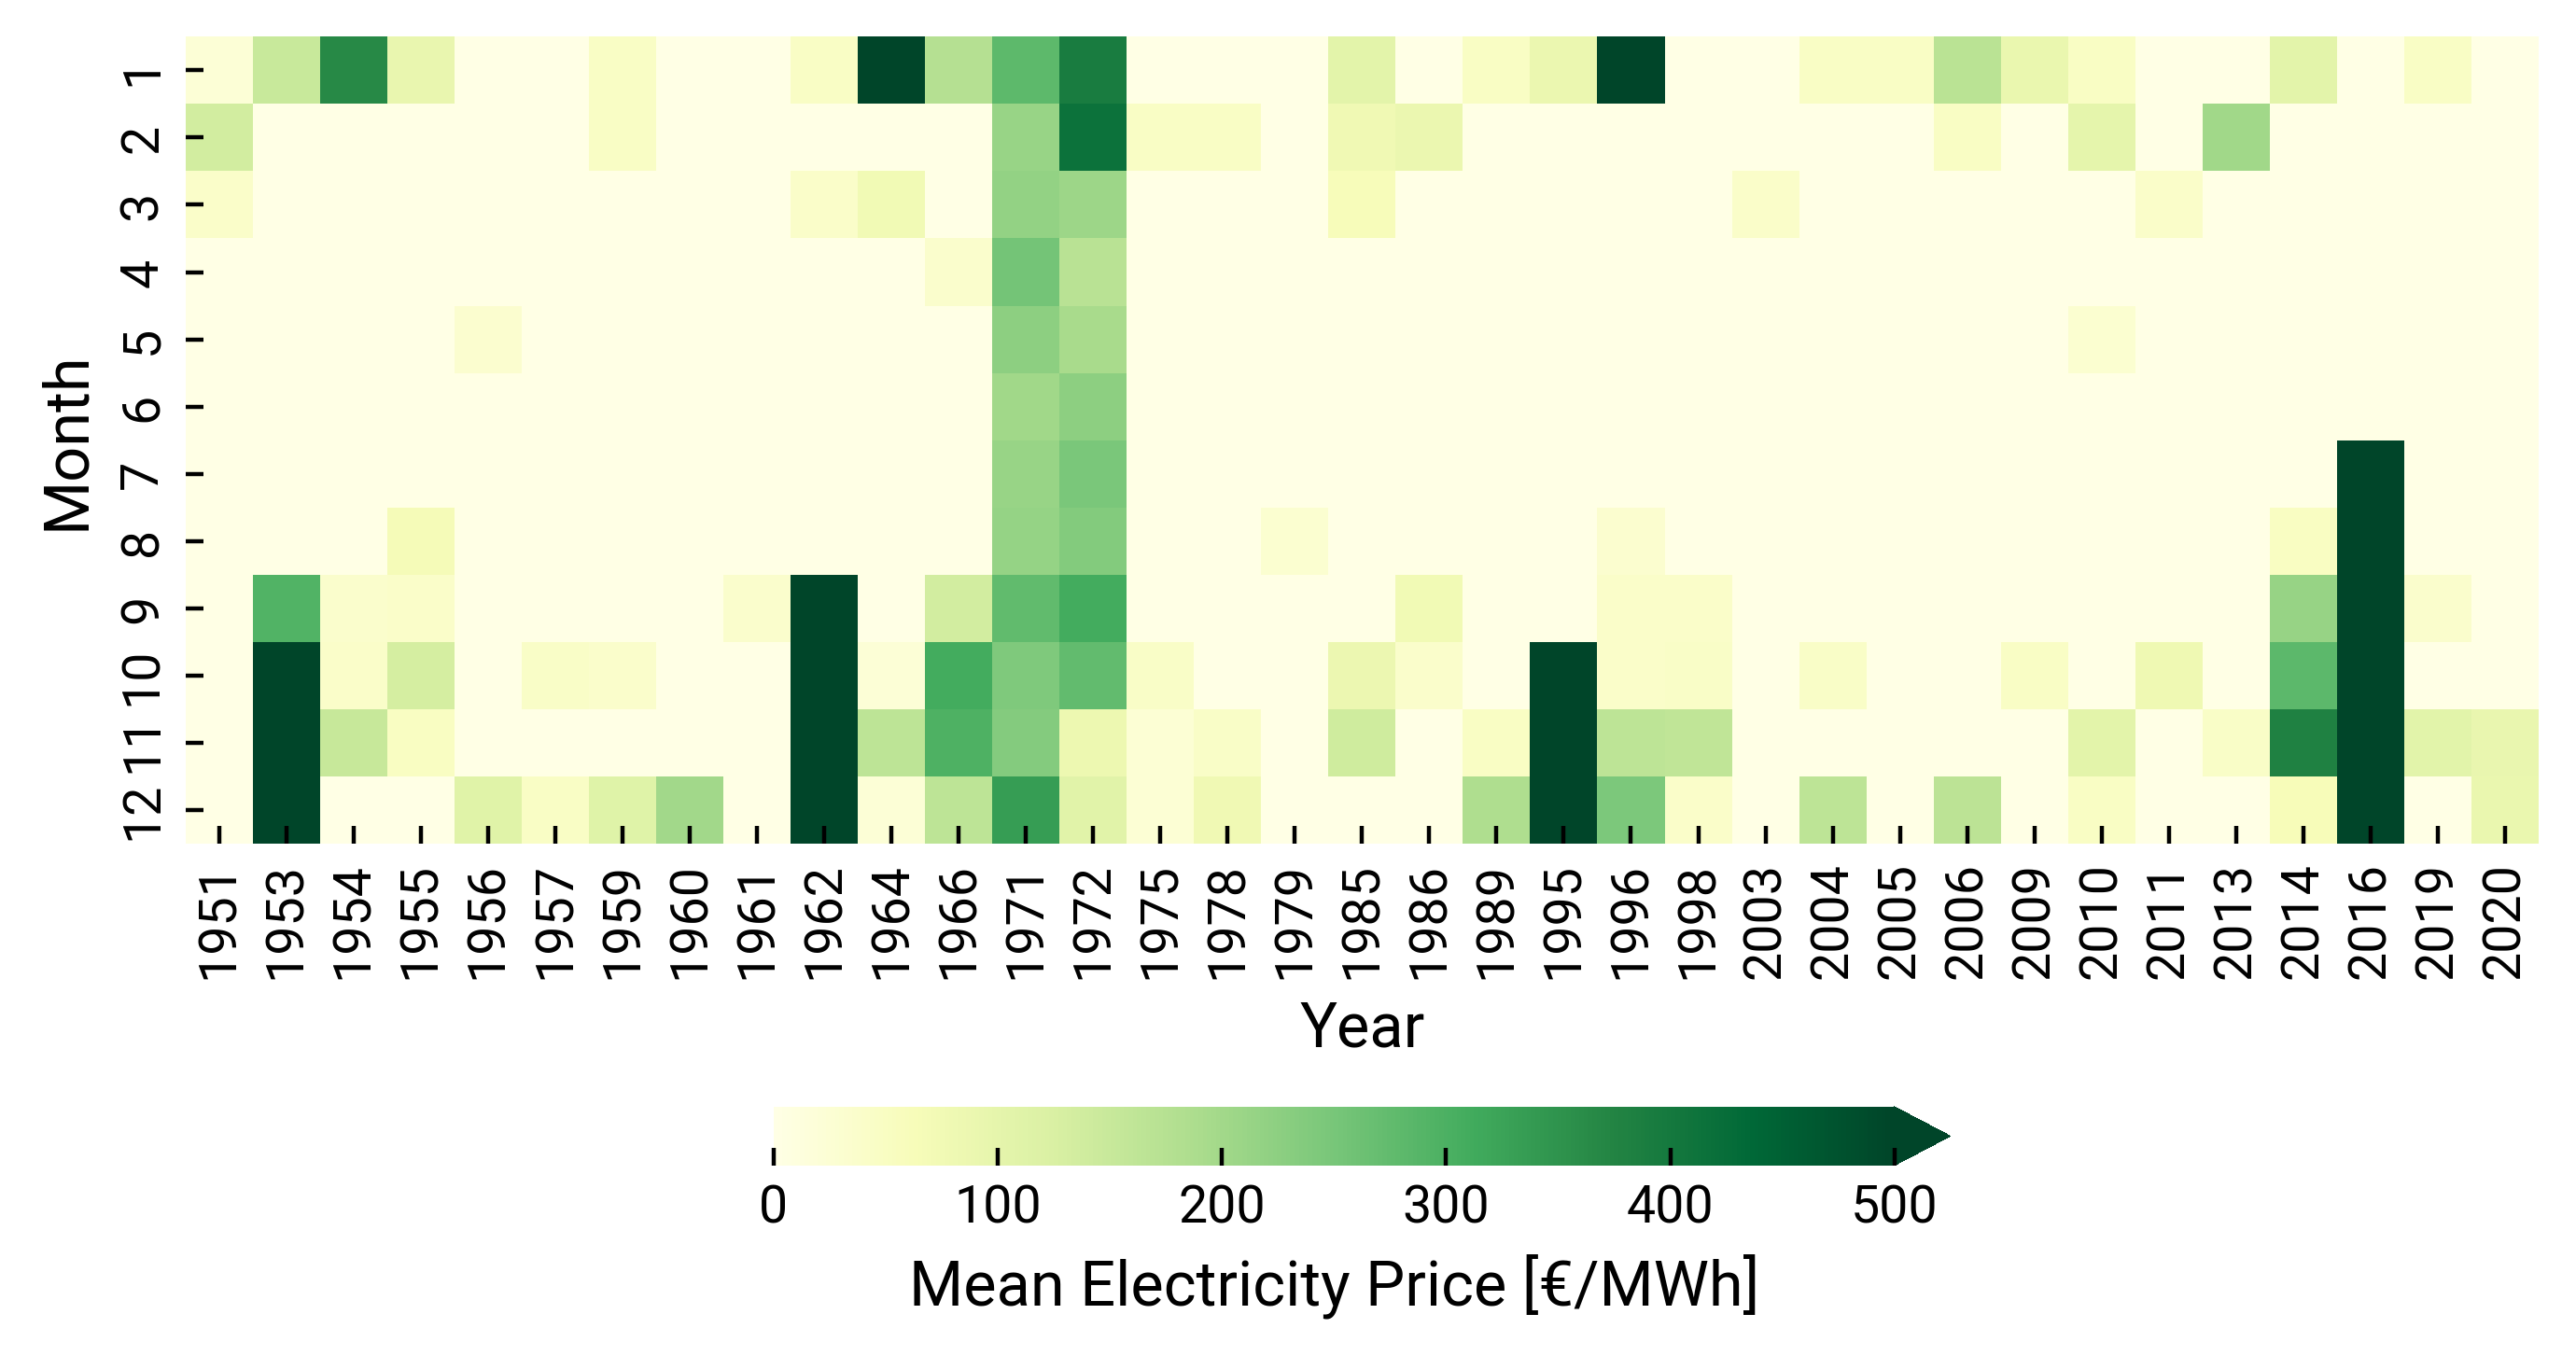

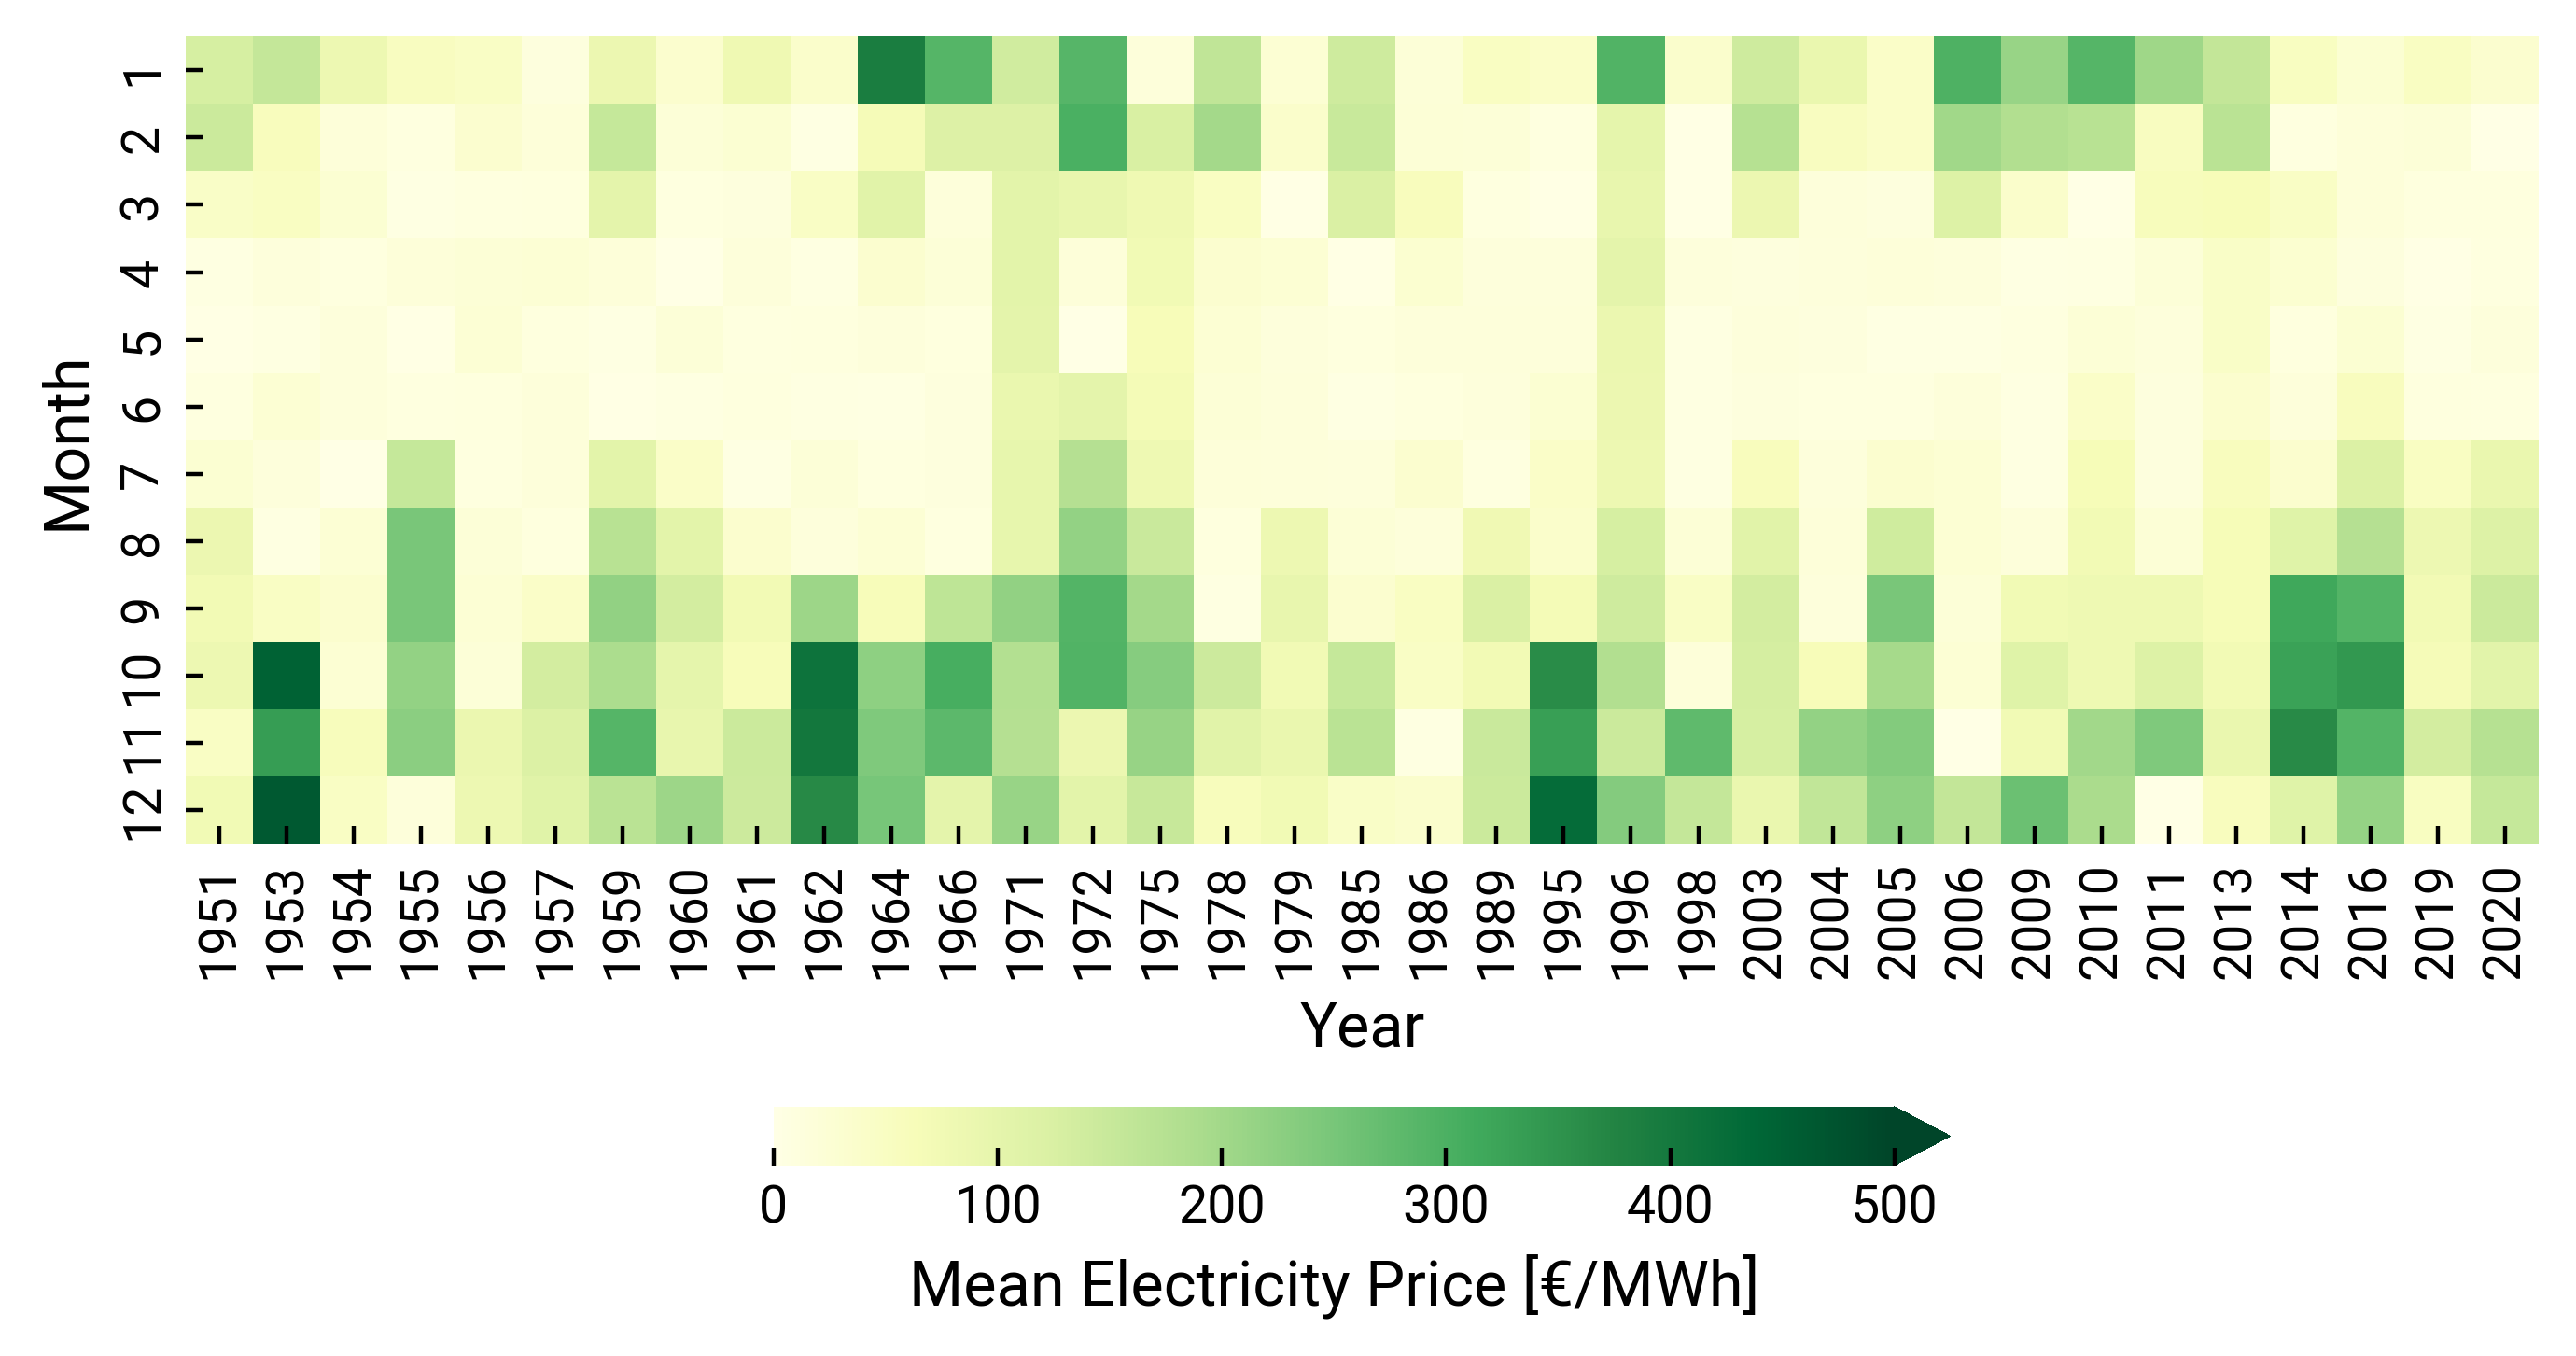

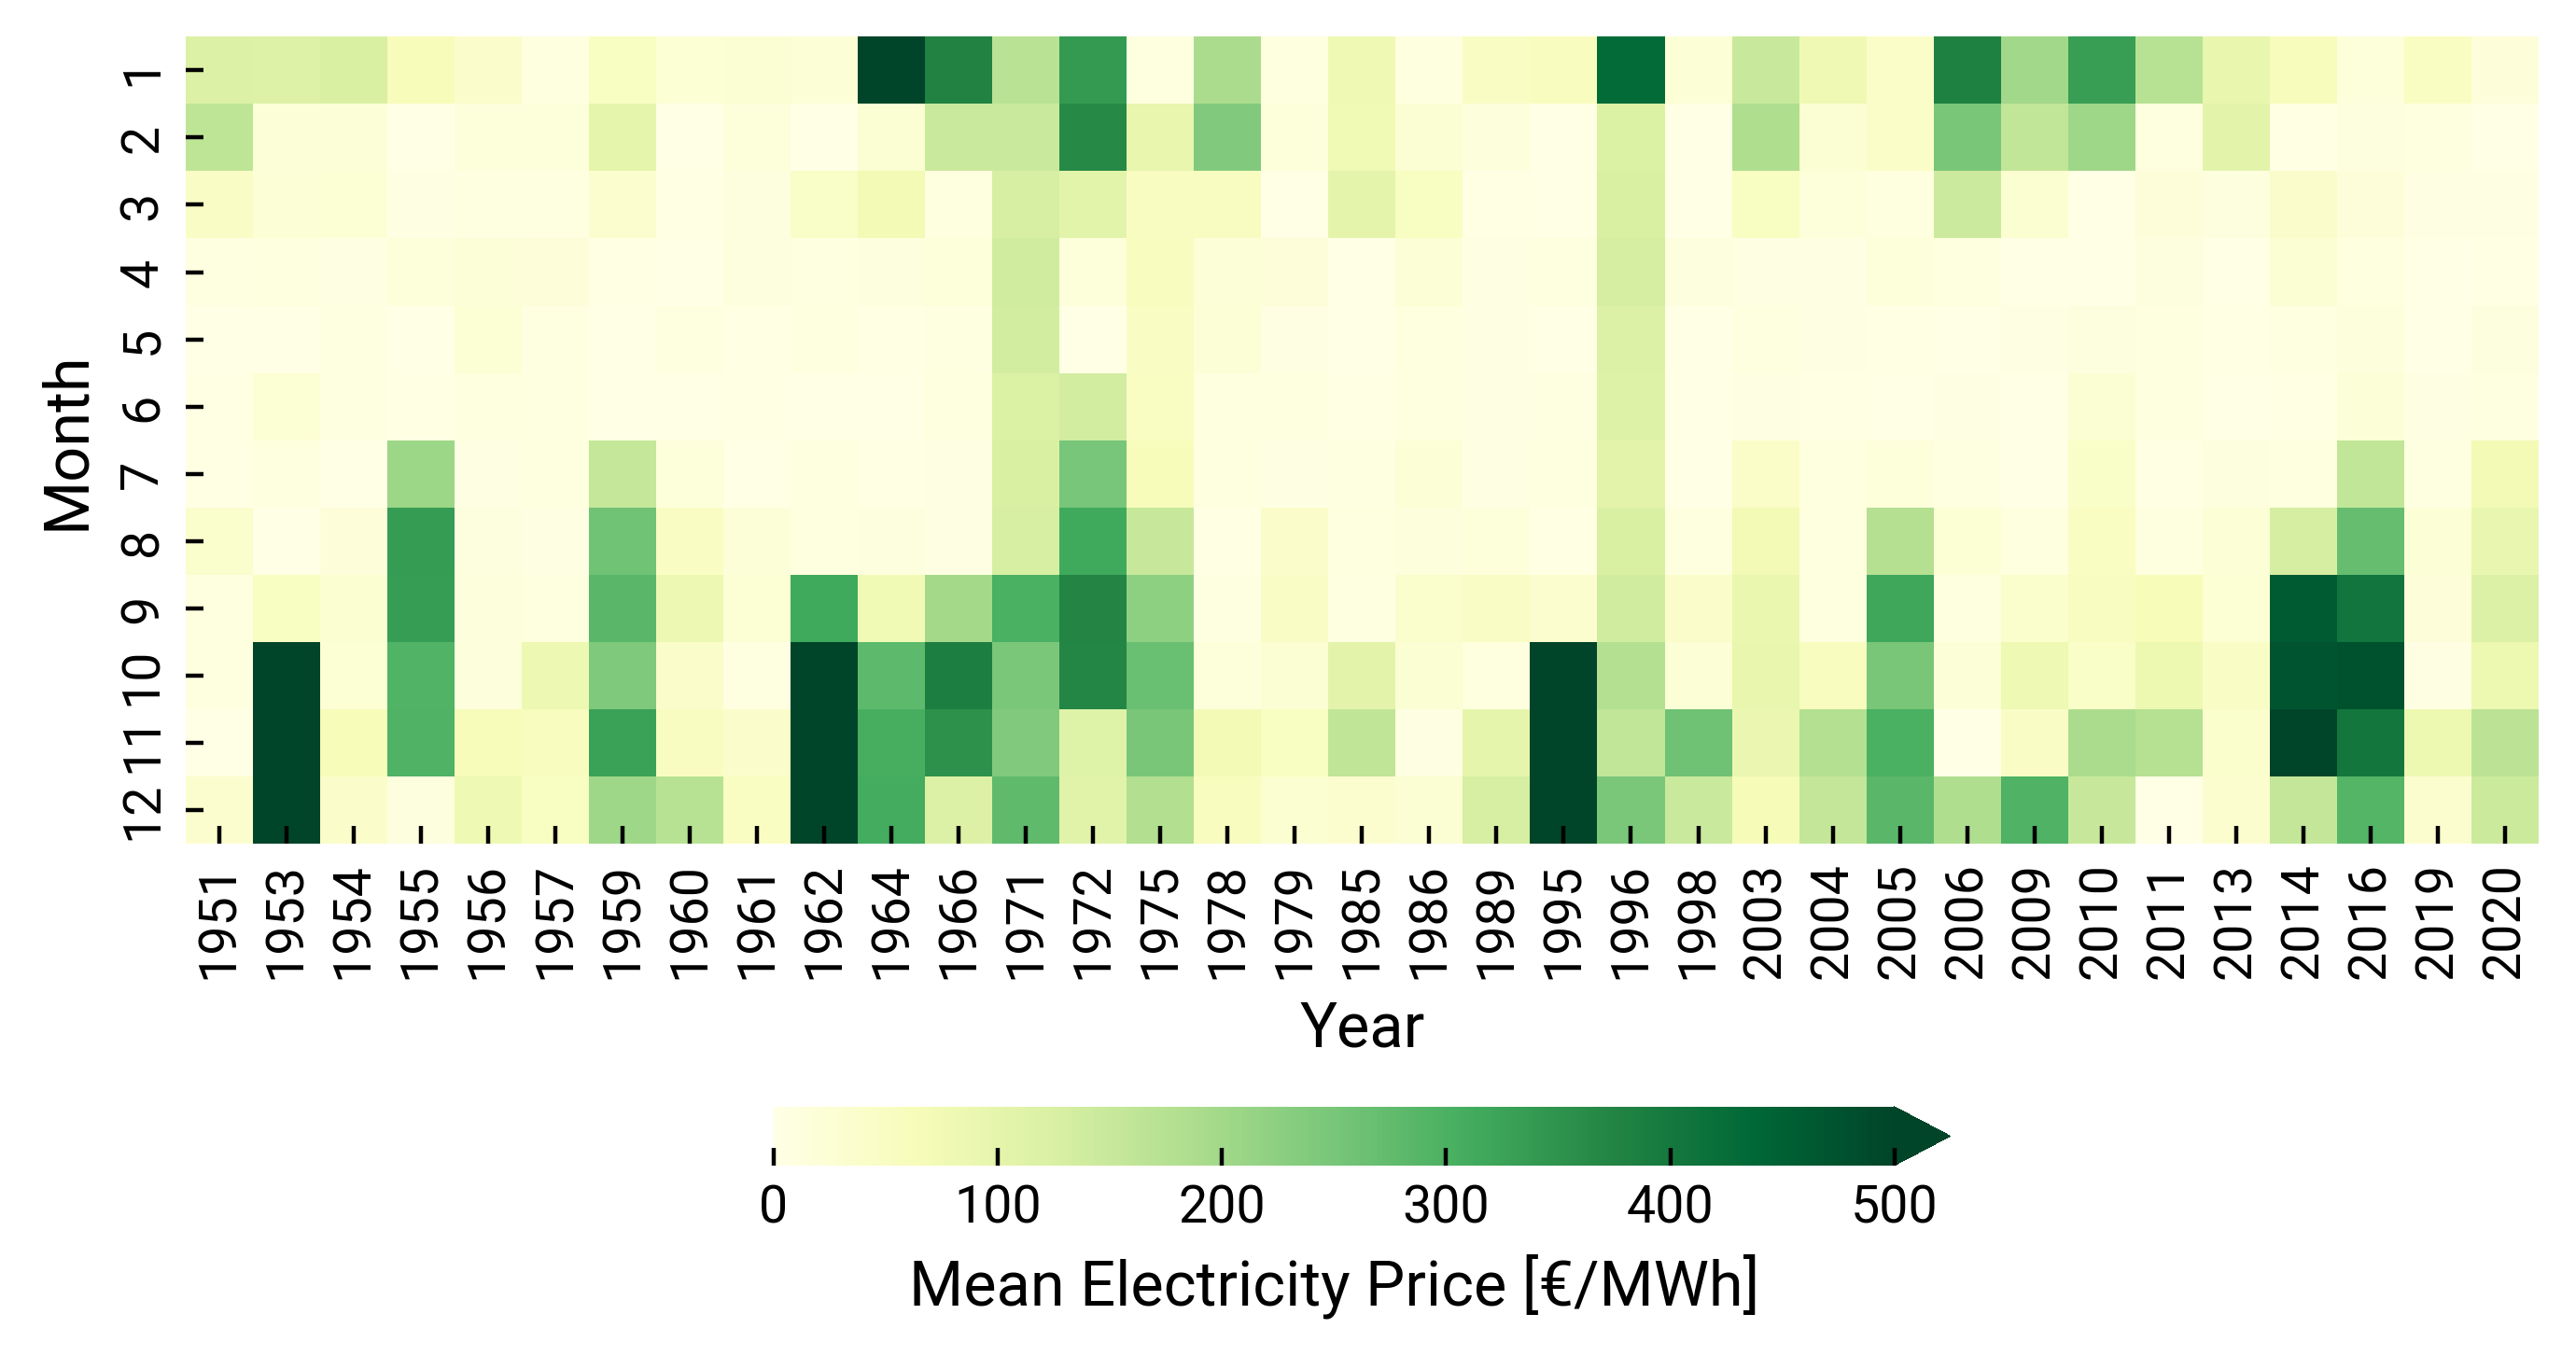

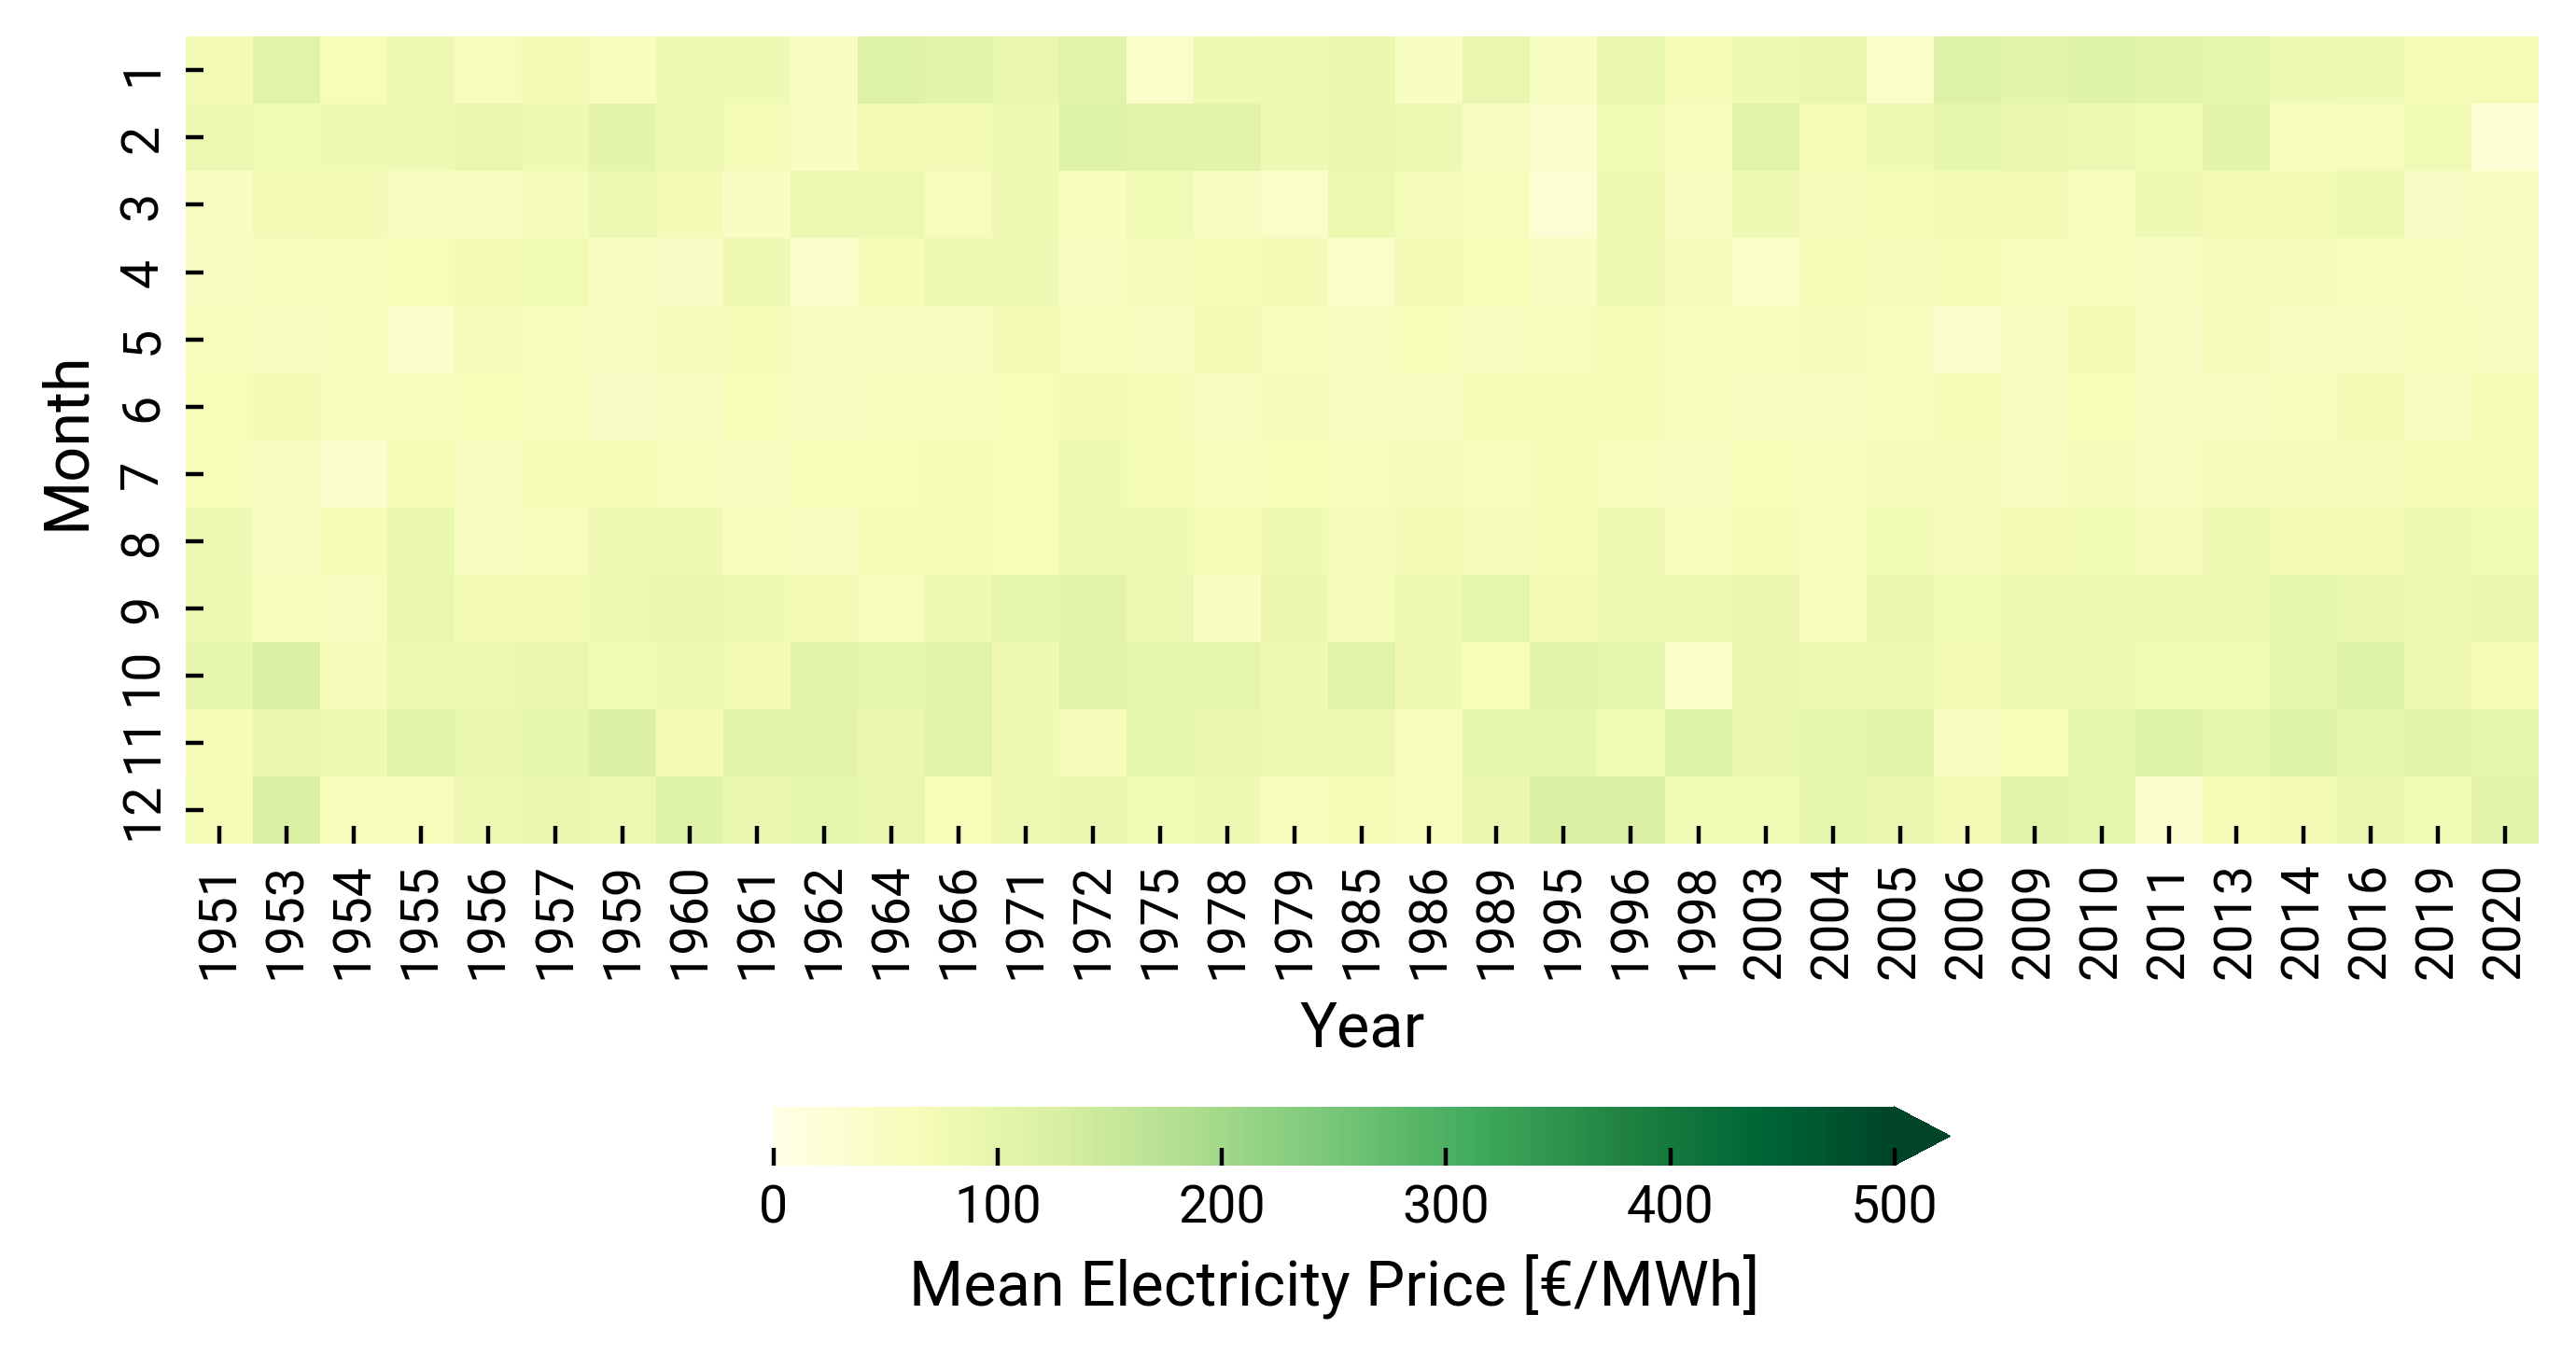

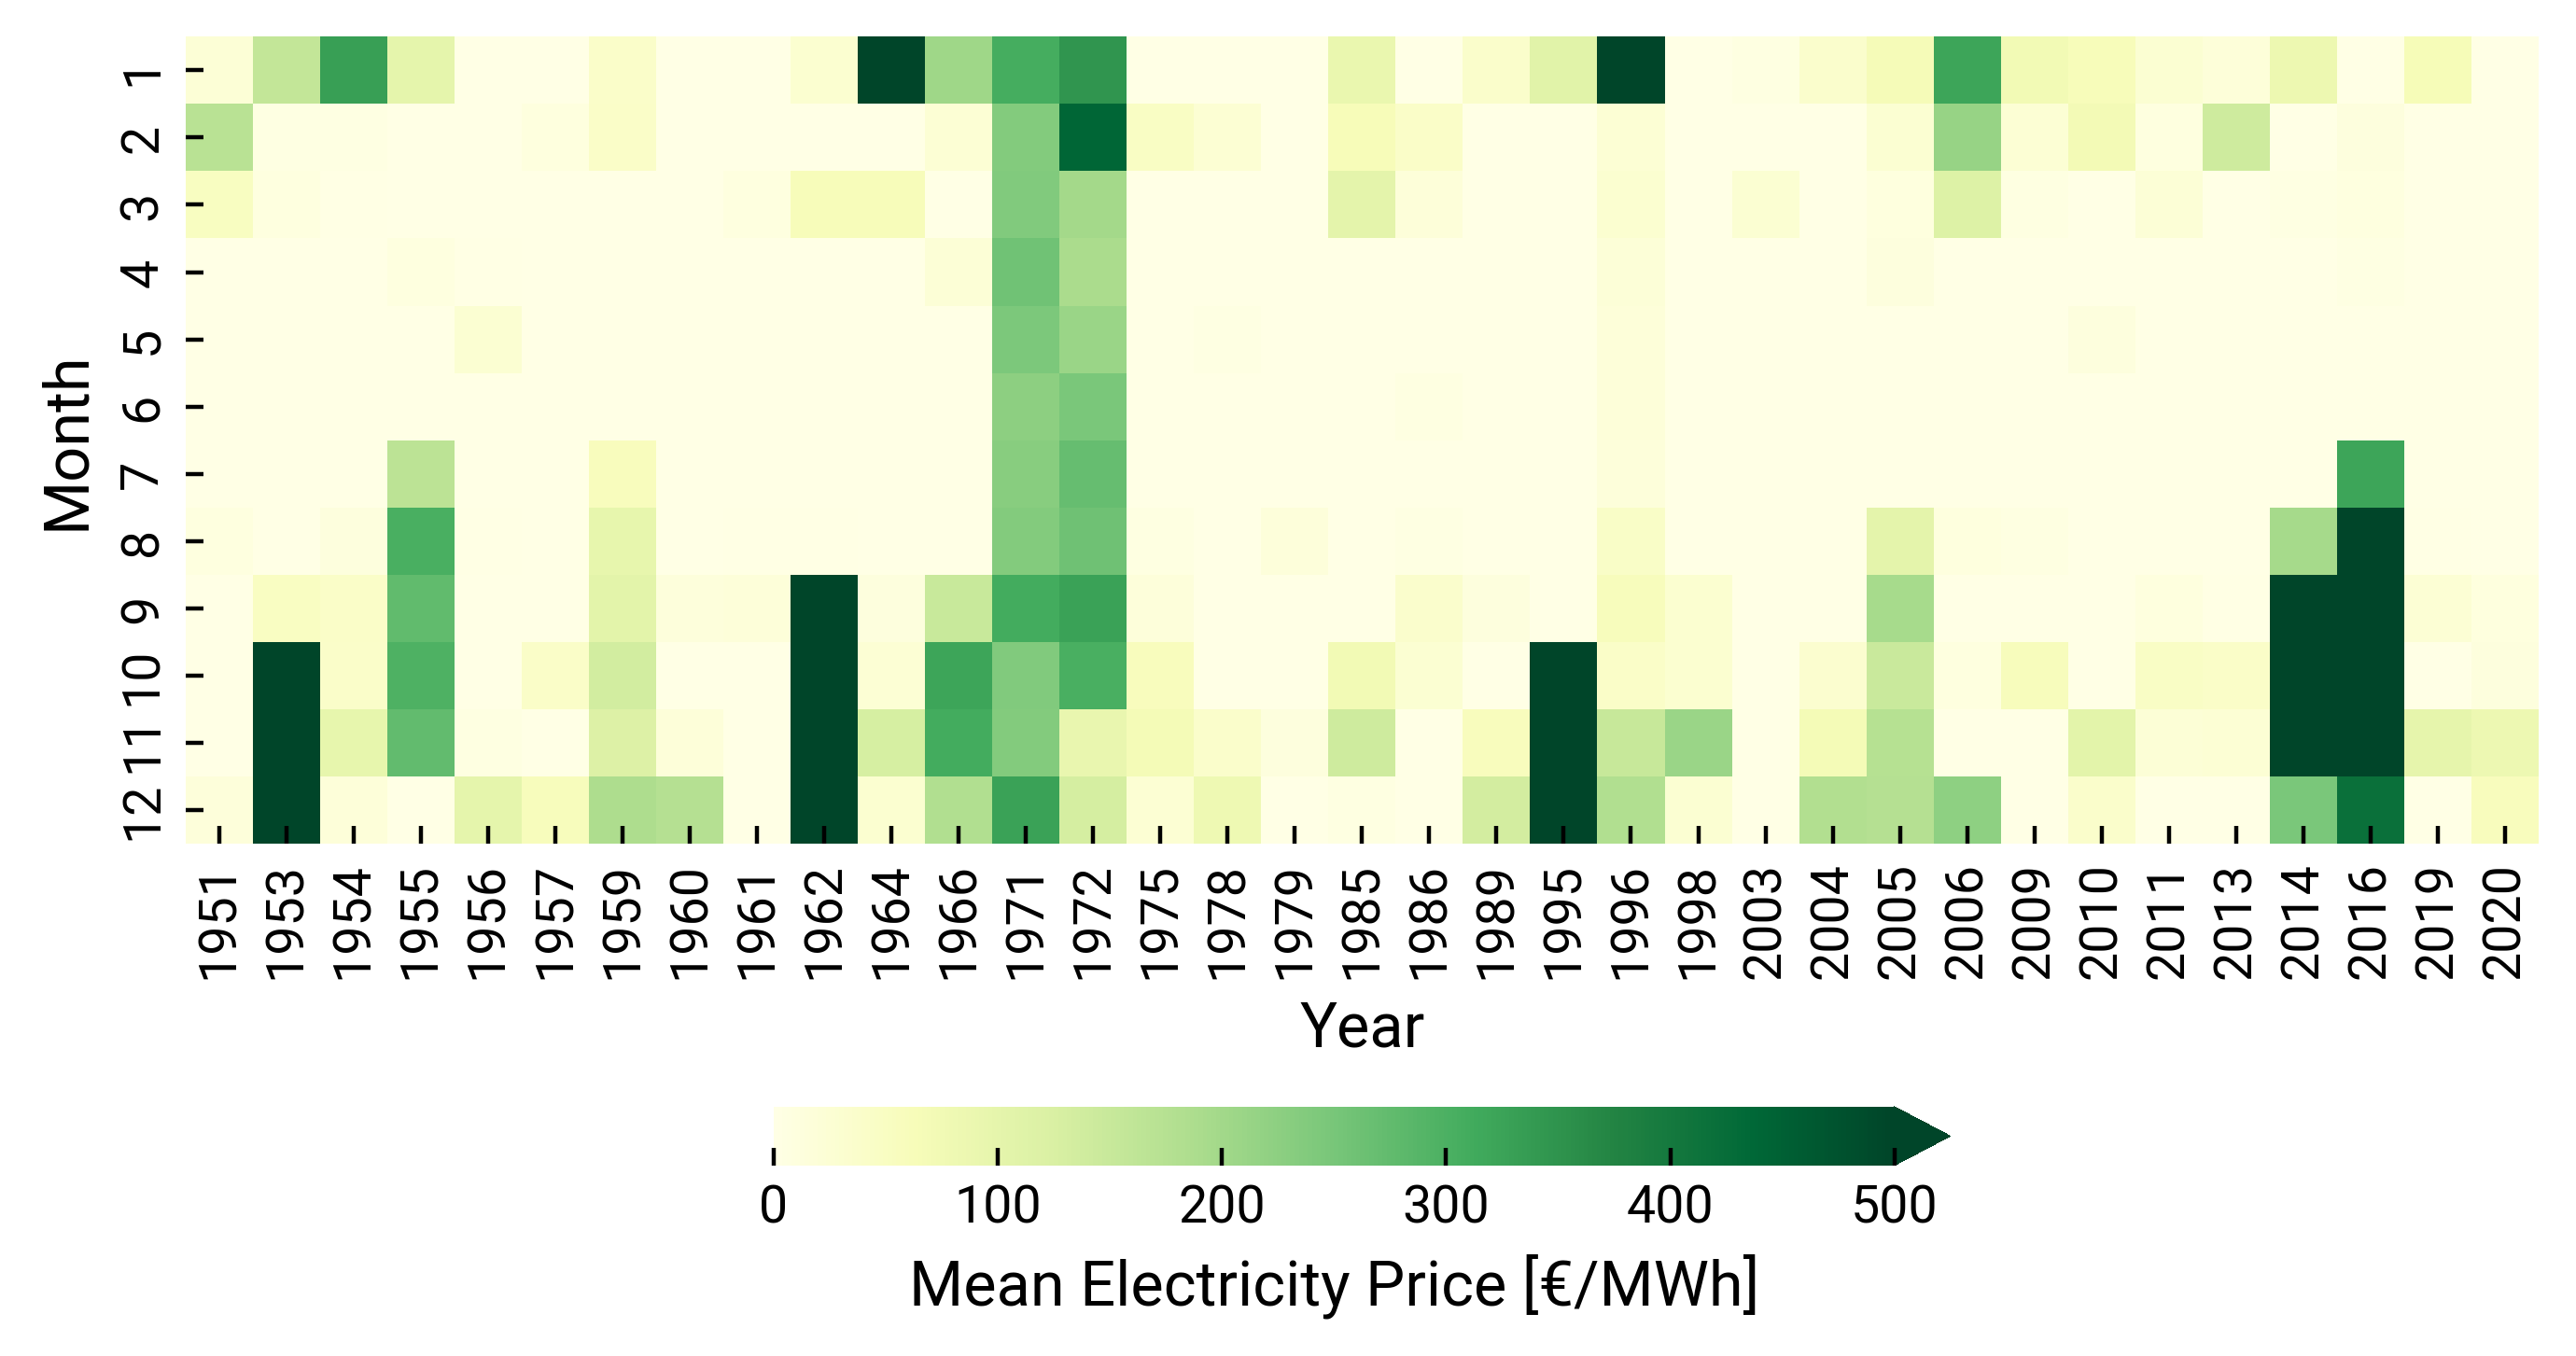

In [63]:
for k, n in ns.items():

    lmp = n.buses_t.marginal_price["electricity"]
    lmp = lmp.groupby([lmp.index.year, lmp.index.month]).mean().unstack()

    fig, ax = plt.subplots()

    sns.heatmap(lmp.T, ax=ax, cmap="YlGn", square=True, cbar_kws={"label": "Mean Electricity Price [€/MWh]", "orientation": "horizontal", "shrink": 0.5, "extend": "max"}, vmin=0, vmax=500)

    plt.ylabel('Month')
    plt.xlabel('Year')

    fn = k.replace("@", "at").replace(" ", "-").replace("%", "perc").replace("€", "EUR").replace("/", "per")
    plt.savefig(f"../../slides/graphics/price-heatmap-{fn}.pdf", bbox_inches='tight')

In [ ]:
pdc = {k: get_price_duration(v) for k, v in ns.items()}
pdc["day-ahead prices 2015-2020"] = history

In [84]:
ldc = {k: get_load_duration(v) for k, v in ns.items()}

In [85]:
crf = pd.DataFrame({k: get_cost_recovery(v).sum(axis=1) for k, v in ns.items()})
crf

,inelastic,VOLL 2000 €/MWh,elasticity -5.3% @ 100 €/MWh,50:50 VOLL & elasticity,elasticity -100% @ 100 €/MWh,elasticity -0.5% @ 100 €/MWh
carrier,,,,,,
battery dis-/charging,99.999993,99.999986,99.999993,100.000002,100.000000,100.000002
battery storage,100.000001,100.000002,100.000001,100.000000,99.999999,99.999999
hydrogen electrolyser,100.000004,100.000001,99.999995,100.000001,100.000007,100.000001
hydrogen fuel cell,100.000000,100.000005,100.000001,99.999992,100.000004,99.999995
hydrogen storage,99.999995,100.000001,99.999999,100.000002,99.999969,100.000001
solar,99.999999,99.999997,99.999998,100.000003,99.999999,100.000001
wind,99.999995,100.000004,99.999998,100.000003,100.000002,100.000004
total,99.999997,100.000002,99.999999,100.000002,100.000001,100.000001


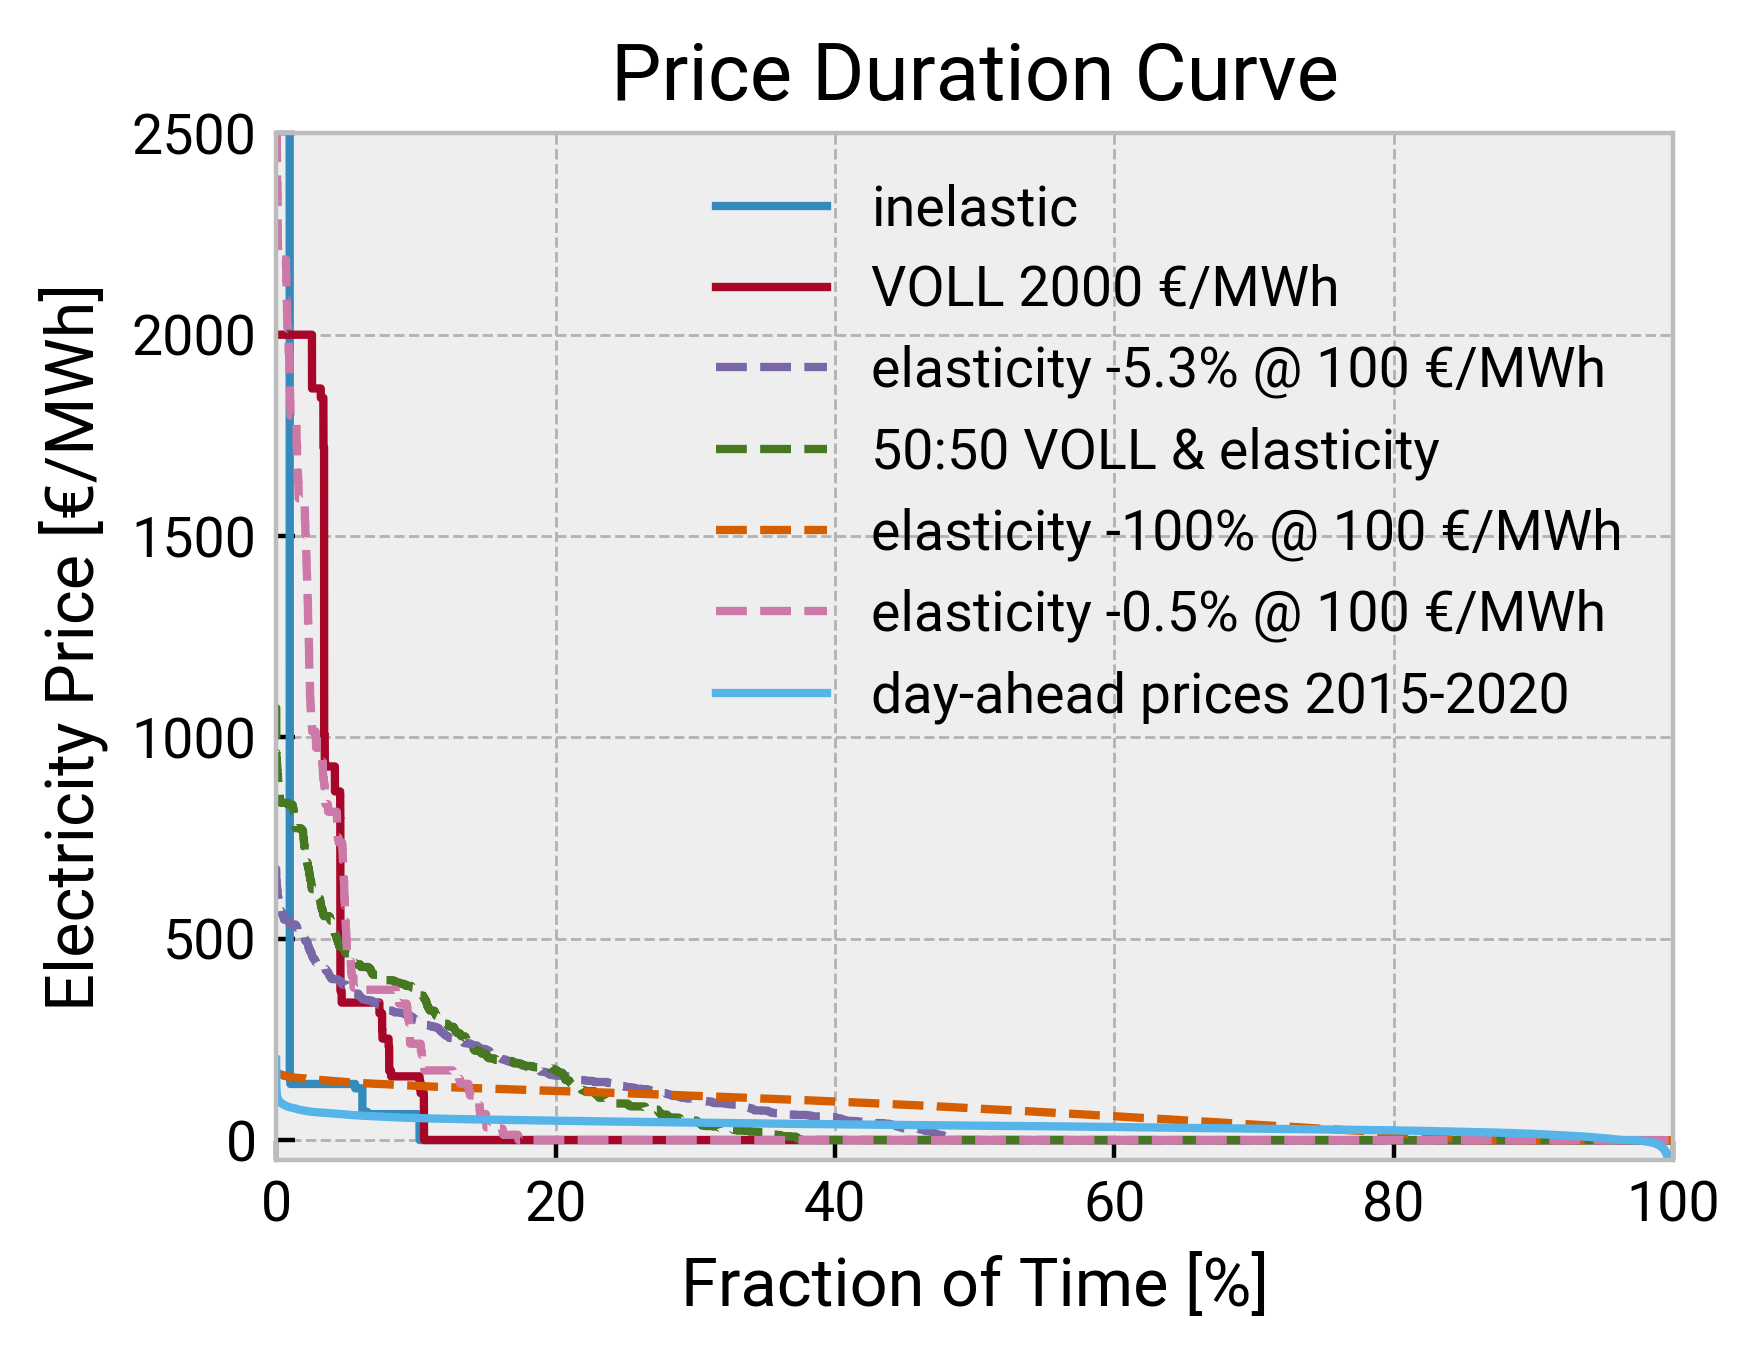

In [86]:
fig, ax = plt.subplots(figsize=(4.5,3.5))

plt.xlabel("Fraction of Time [%]")
plt.ylabel("Electricity Price [€/MWh]")
plt.xlim(0, 100)
plt.ylim(-50, 2500)
plt.title("Price Duration Curve")

for i, c in enumerate(pdc):

    linestyle = "--" if "elasticity" in c else "-"

    pdc[c].plot(ax=ax, label=c, legend=True, linestyle=linestyle, linewidth=1.5)
    plt.grid(axis="both")

    plt.savefig(f"../../slides/graphics/pdc-{i}.pdf", bbox_inches='tight')


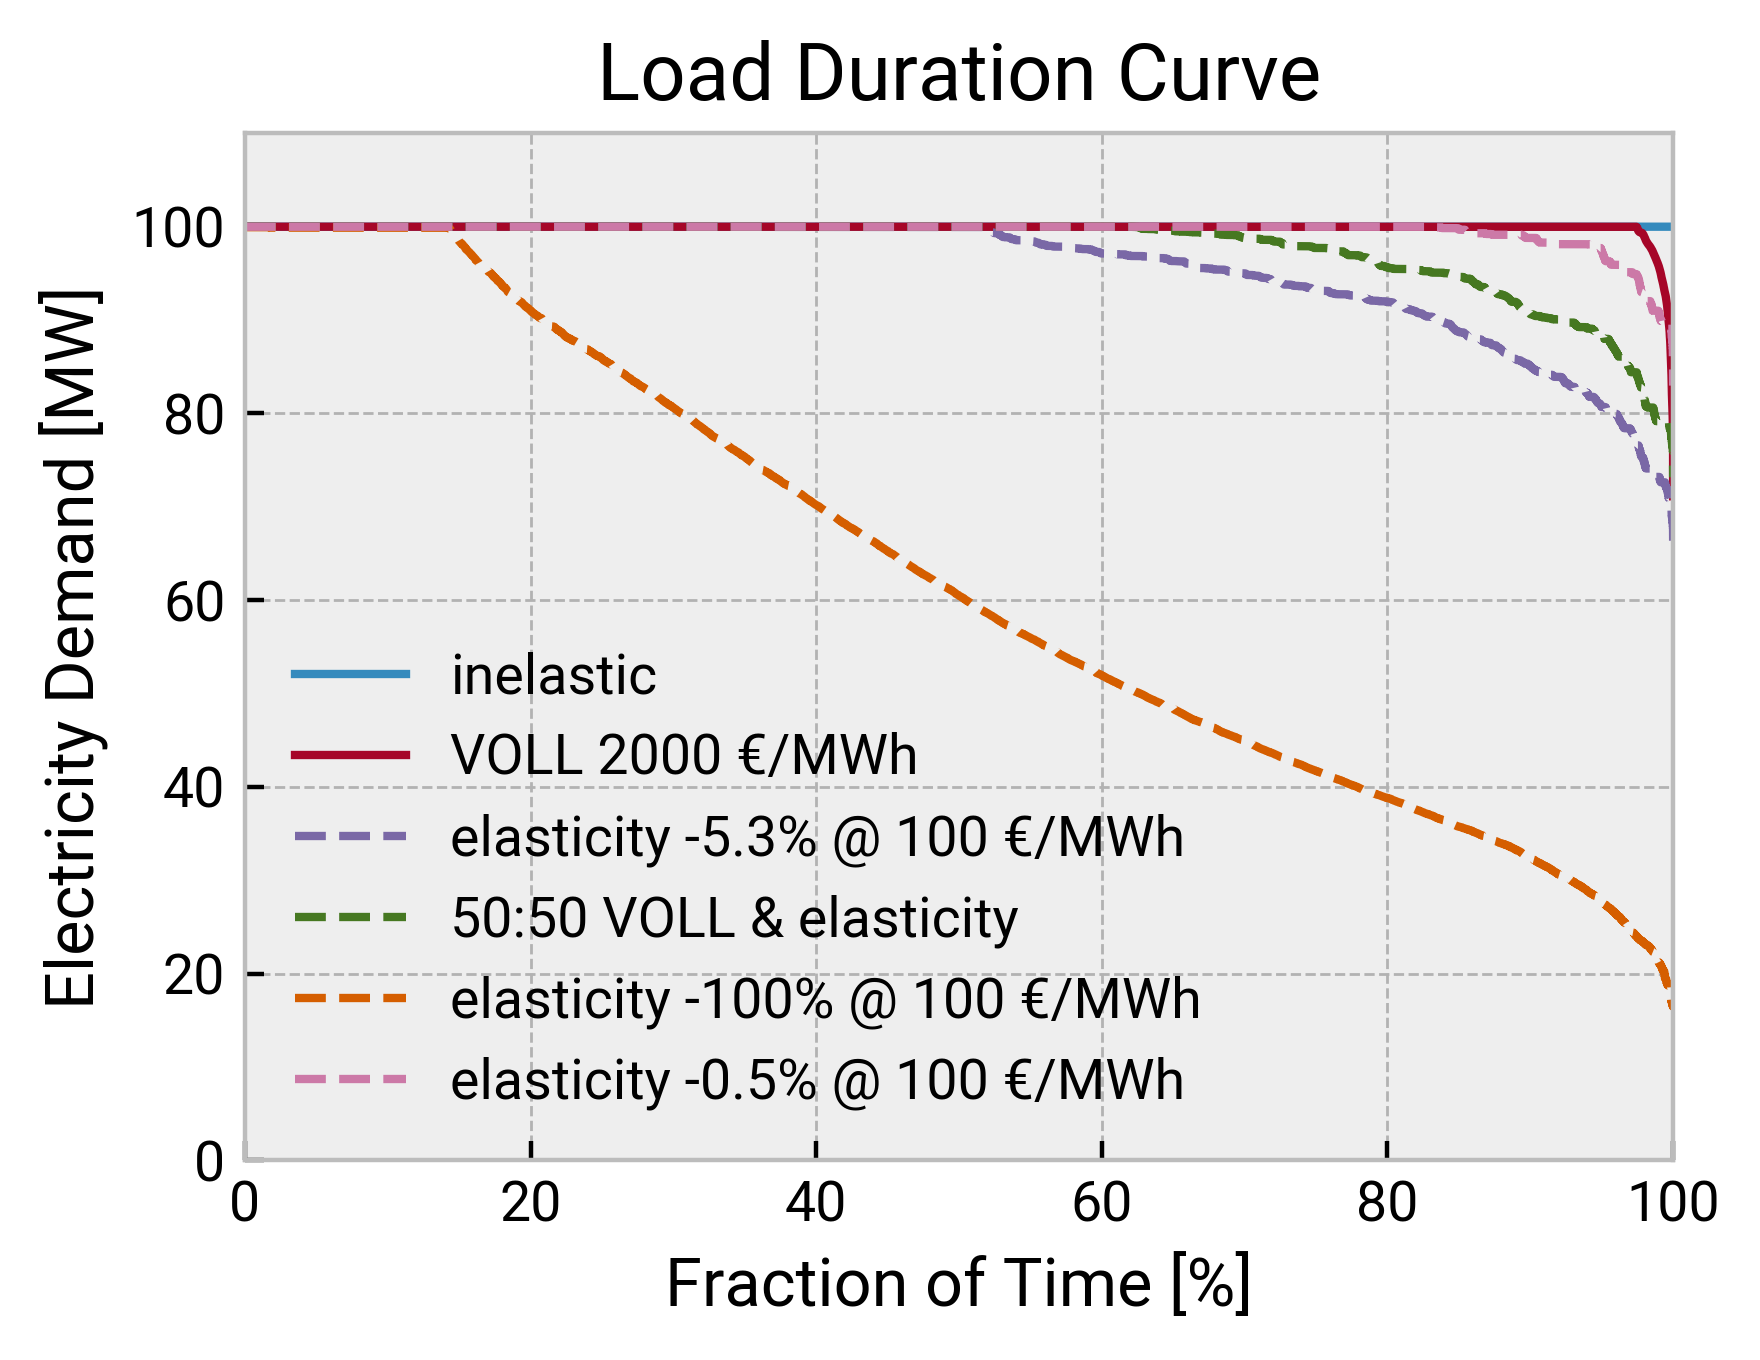

In [87]:
fig, ax = plt.subplots(figsize=(4.5,3.5))

plt.xlabel("Fraction of Time [%]")
plt.ylabel("Electricity Demand [MW]")
plt.xlim(0, 100)
plt.ylim(0, 110)
plt.title("Load Duration Curve")

for i, c in enumerate(ldc):

    linestyle = "--" if "elasticity" in c else "-"

    ldc[c].plot(ax=ax, label=c, legend=True, linestyle=linestyle, linewidth=1.5)
    plt.grid(axis="both")

    plt.savefig(f"../../slides/graphics/ldc-{i}.pdf", bbox_inches='tight')


In [71]:
files = {
    "elasticity -5.3% @ 100 €/MWh": "../../results/35a-35a/network_solved_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000.nc",
    "perfect foresight": "../../results/35a-35a/network_myopic_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000_ST-number_years+35-perfect_foresight+true.nc",
    "myopic foresight (4/2 days), no bidding": "../../results/35a-35a/network_myopic_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000_ST-number_years+35-horizon+96-overlap+48-hydrogen_bid+0-battery_bid+0.nc",
    "myopic foresight (4/2 days)": "../../results/35a-35a/network_myopic_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000_ST-number_years+35-horizon+96-overlap+48.nc",
    # "myopic foresight (4/2 days), capacities +1%": "../../results/35a-35a/network_myopic_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000_ST-number_years+35-horizon+96-overlap+48-perturbation+1.01.nc",
    # "myopic foresight (4/2 days), capacities -1%": "../../results/35a-35a/network_myopic_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000_ST-number_years+35-horizon+96-overlap+48-perturbation+0.99.nc",
    "myopic foresight (4/2 days), capacities +5%": "../../results/35a-35a/network_myopic_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000_ST-number_years+35-horizon+96-overlap+48-perturbation+1.05.nc",
    "myopic foresight (4/2 days), capacities -5%": "../../results/35a-35a/network_myopic_LT-country+DE-number_years+35-elastic+true-elastic_intercept+2000_ST-number_years+35-horizon+96-overlap+48-perturbation+0.95.nc",
}

ns = {k: pypsa.Network(v) for k, v in files.items()}

pdc = {k: get_price_duration(v) for k, v in ns.items()}
ldc = {k: get_load_duration(v) for k, v in ns.items()}
crf = pd.DataFrame({k: get_cost_recovery(v).sum(axis=1) for k, v in ns.items()})


INFO:pypsa.io:Imported network network_solved_LT-country+DE-number_years+35-inelastic+true.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_myopic_LT-country+DE-number_years+35-inelastic+true_ST-number_years+35-perfect_foresight+true.nc has buses, carriers, generators, links, loads, stores


type: 'electricity'

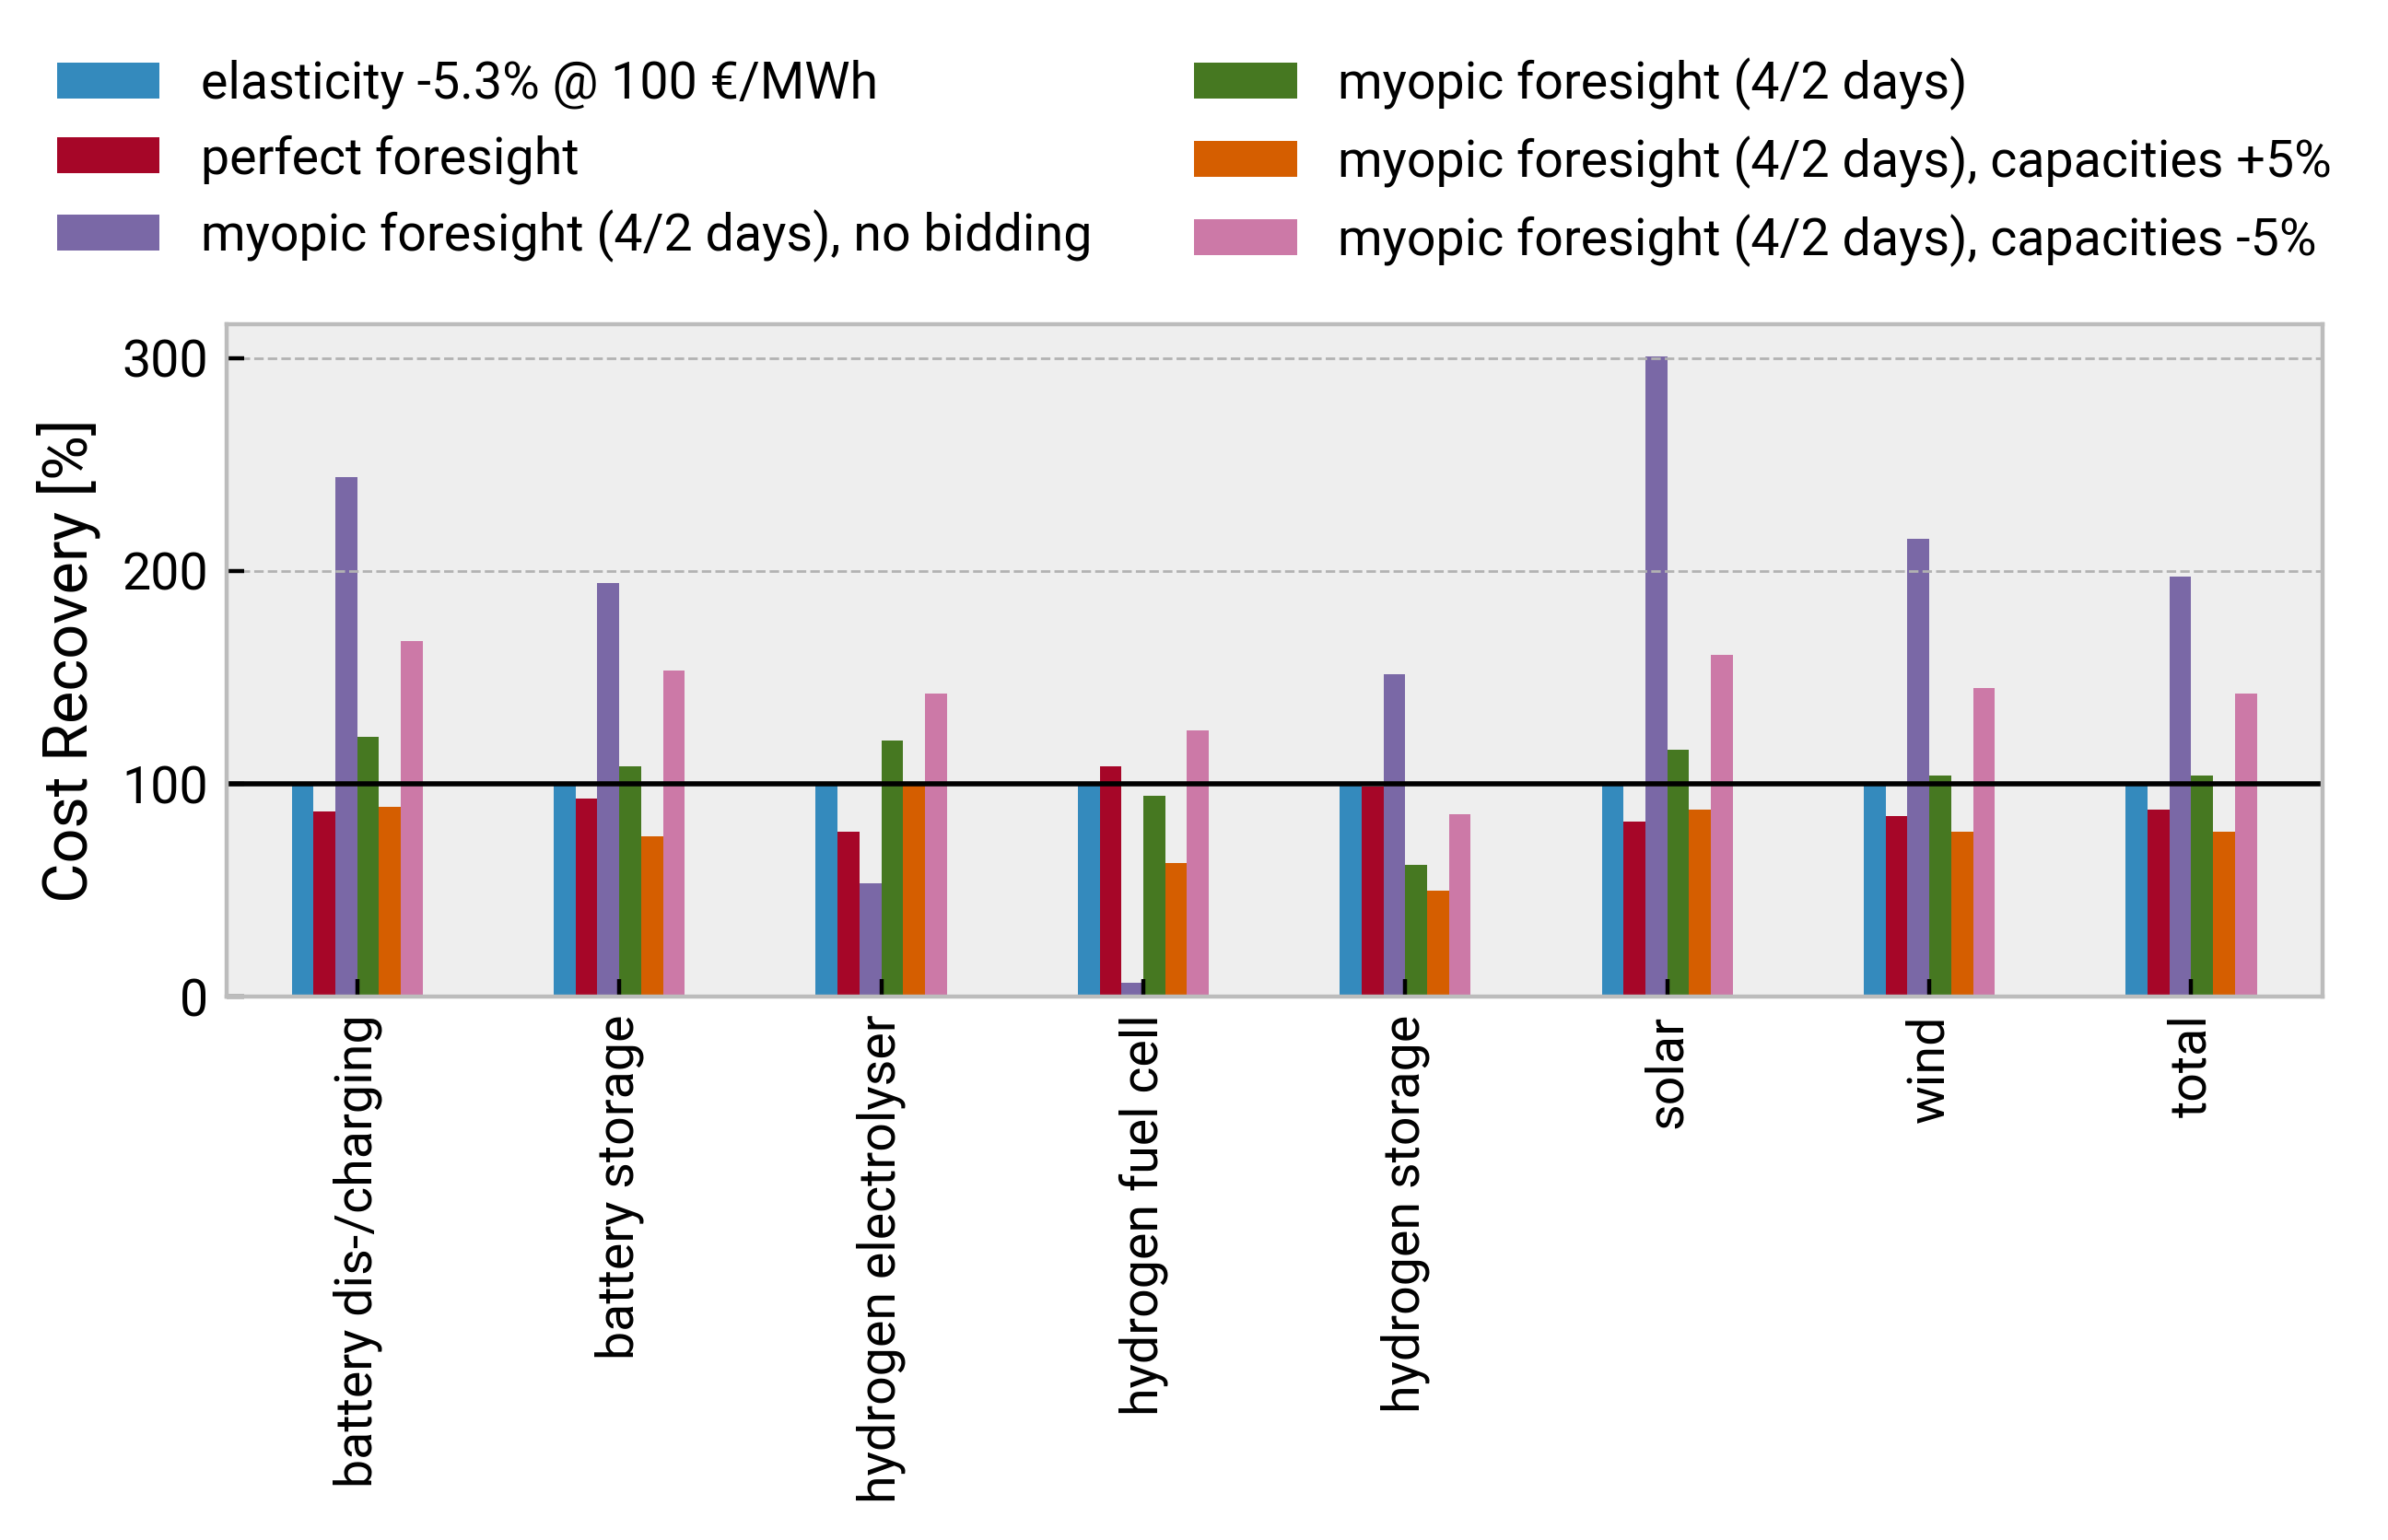

In [58]:
fig, ax = plt.subplots(figsize=(6.5,3.5))
crf.plot.bar(ax=ax, legend=False)
plt.xlabel("")
plt.ylabel("Cost Recovery [%]")
plt.grid(axis="y")
ax.axhline(100, color='k', linewidth=1)
fig.legend(ncol=2, loc="outside upper right", bbox_to_anchor=(1, 1.2))

plt.savefig(f"../../slides/graphics/crf.pdf", bbox_inches='tight')

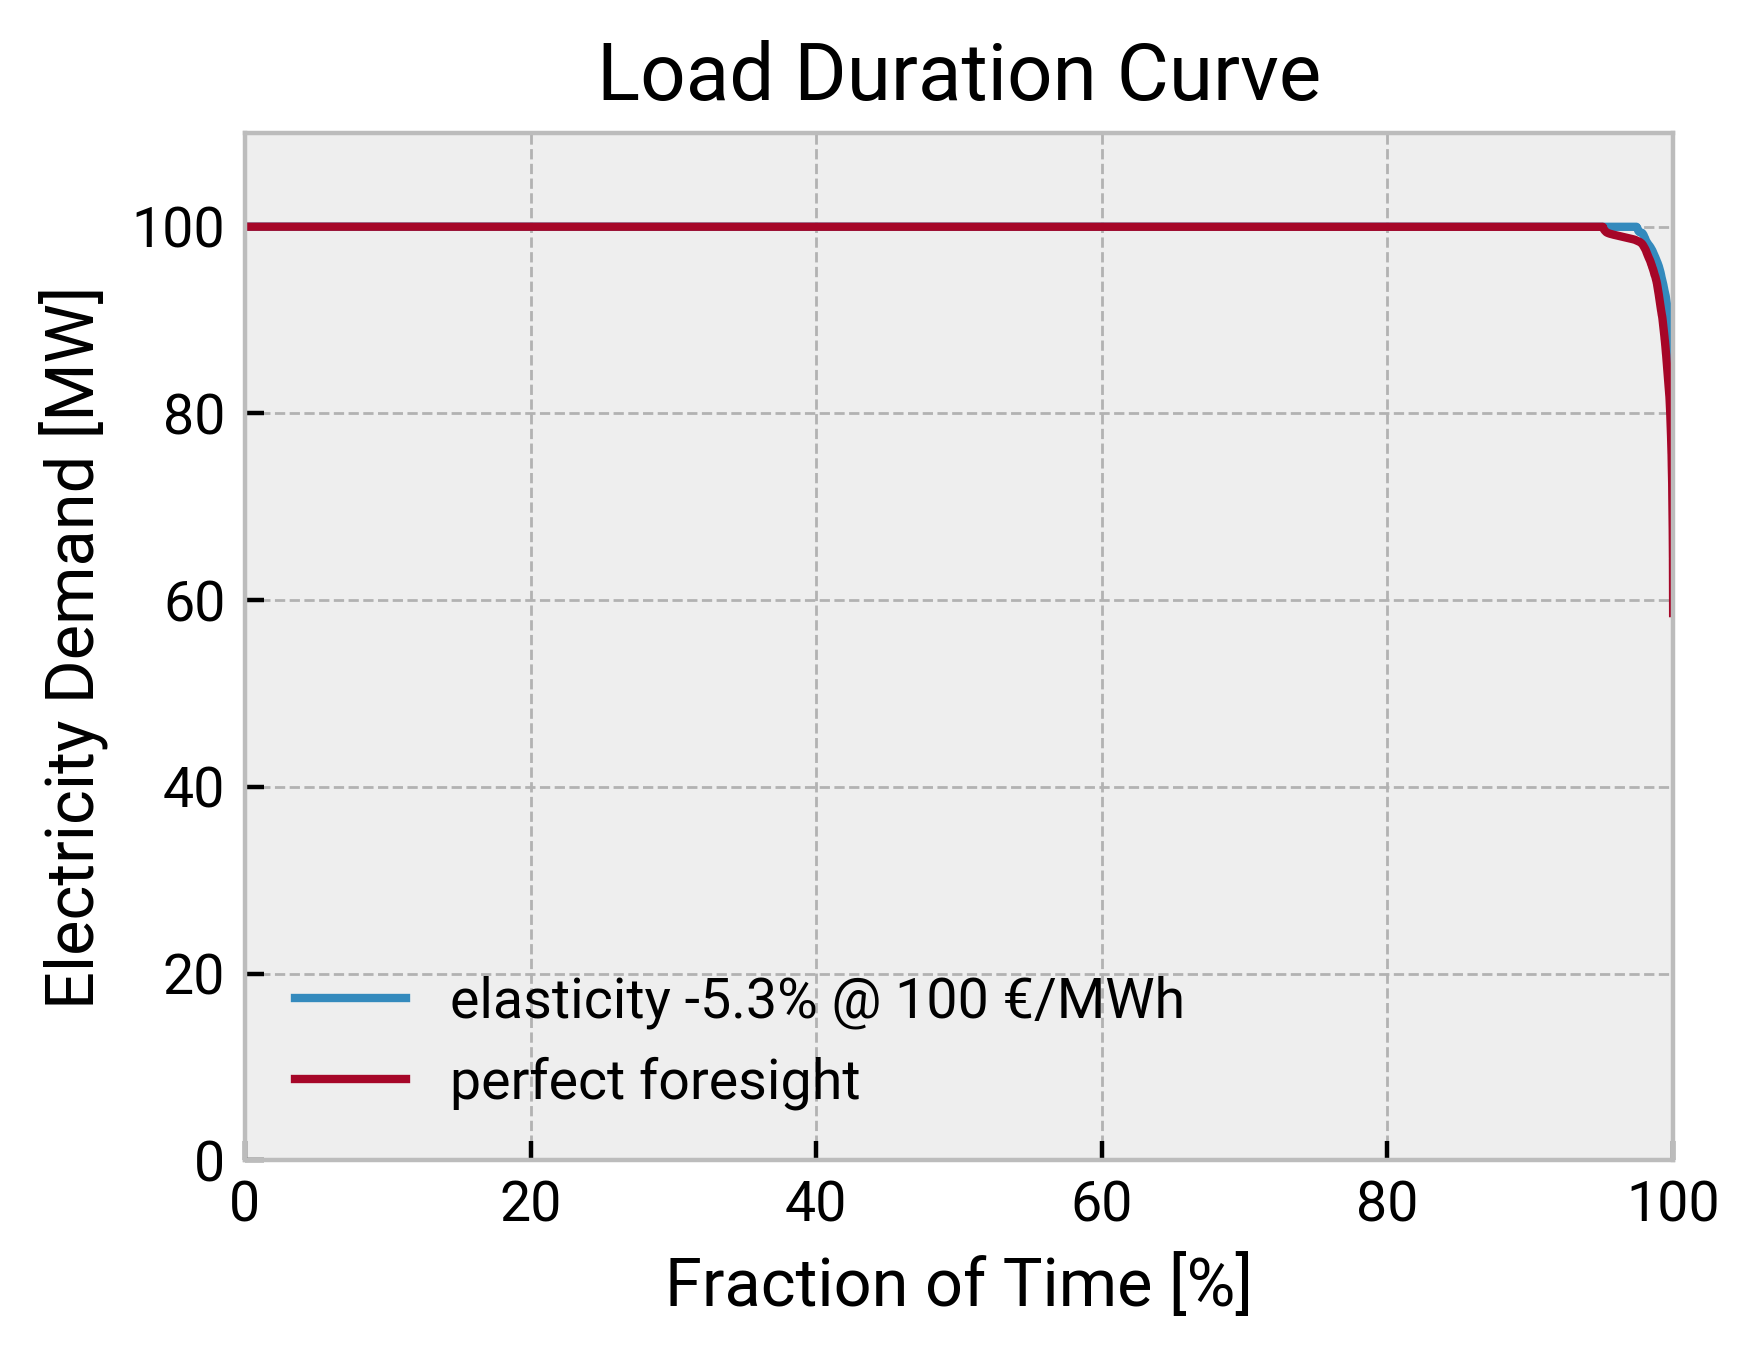

In [69]:
fig, ax = plt.subplots(figsize=(4.5,3.5))

plt.xlabel("Fraction of Time [%]")
plt.ylabel("Electricity Demand [MW]")
plt.xlim(0, 100)
plt.ylim(0, 110)
plt.title("Load Duration Curve")

for i, c in enumerate(ldc):

    linestyle = "--" if c.startswith("myopic") else "-"
    alpha = 0.5 if "capacities" in c else 1.0

    ldc[c].plot(ax=ax, label=c, legend=True, linestyle=linestyle, linewidth=1.5, alpha=alpha)
    plt.grid(axis="both")

    plt.savefig(f"../../slides/graphics/ldc-myopic-{i}.pdf", bbox_inches='tight')


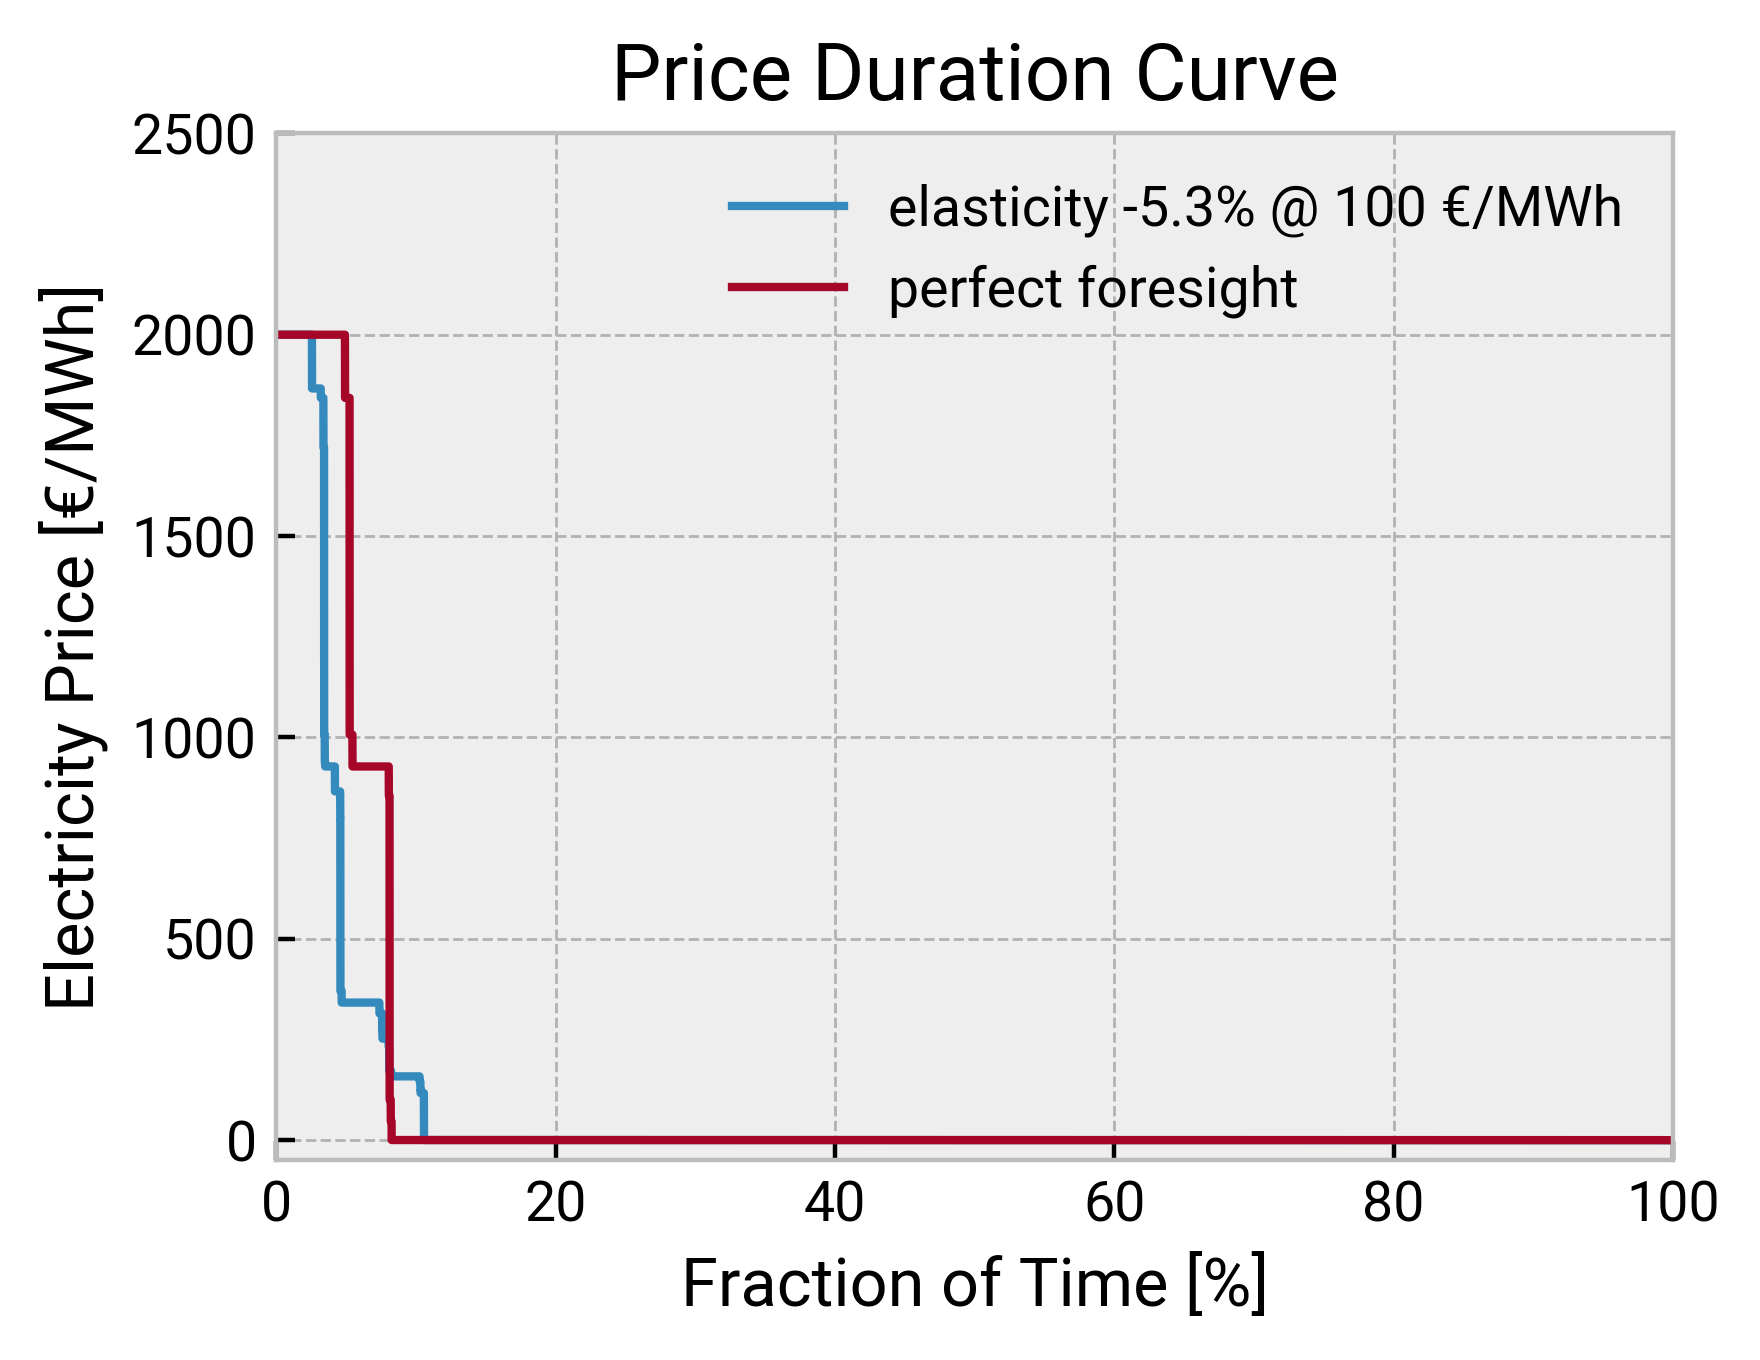

In [70]:
fig, ax = plt.subplots(figsize=(4.5,3.5))

plt.xlabel("Fraction of Time [%]")
plt.ylabel("Electricity Price [€/MWh]")
plt.xlim(0, 100)
plt.ylim(-50, 2500)
plt.title("Price Duration Curve")

for i, c in enumerate(pdc):

    linestyle = "--" if c.startswith("myopic") else "-"
    alpha = 0.5 if "capacities" in c else 1.0

    pdc[c].plot(ax=ax, label=c, legend=True, linestyle=linestyle, linewidth=1.5, alpha=alpha)
    plt.grid(axis="both")

    plt.savefig(f"../../slides/graphics/pdc-myopic-{i}.pdf", bbox_inches='tight')
